In [1]:
import pyvo as vo
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,LogNorm,PowerNorm
import numpy as np
import numpy.ma as ma
import re
import astropy
from astropy import table
from astropy.io import fits,ascii
from astropy.table import Table,vstack,pprint, Column
from astropy.coordinates import SkyCoord ,ICRS, Galactic
import astropy.units as u
from astropy.time import Time
from astropy.units import Quantity
from astroquery.vizier import Vizier
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from astroquery.xmatch import XMatch
from scipy.stats import norm
from DEF import *
import mpl_scatter_density
from astroquery.simbad import Simbad

size = Quantity(25, unit="arcmin")
big_radius=Quantity(3, unit="deg")
nom=["Gaia2","Xmm"] #Ordre important pour l'output de Crossing

url_gaia="https://gea.esac.esa.int/tap-server/conesearch?TABLE=gaiadr3.gaia_source&IDCOL=source_id&RACOL=ra&DECCOL=dec&"
url_gaia2="http://vizier.cds.unistra.fr/viz-bin/conesearch/I/355/gaiadr3?"
#url_xmm="http://vizier.cds.unistra.fr/viz-bin/conesearch/IX/65/xmm4d11s?"
url_xmm="http://vizier.cds.unistra.fr/viz-bin/conesearch/IX/68/xmm4d12s?" #Test
url_obs_xmm="http://vizier.cds.unistra.fr/viz-bin/conesearch/IX/65/summary?"

dic={"Gaia":[url_gaia,"designation","ra","dec"],"Xmm":[url_xmm,"Source","RA_ICRS","DE_ICRS"],"Gaia2":[url_gaia2,"DR3Name","RA_ICRS","DE_ICRS"]}

#Gaia: #f48c06
#XMM : #0096c7
g=-1
d=4.5
h=14
b=-11


In [2]:
%%html
<style>
.output_wrapper .output {
  overflow-y: visible;
  height: fit-content;
}
</style>
table.Conf(default_notebook_table_class)

# Partie TABLE

In [3]:

choix=0# int(input("0:Local catalog\n1:Conesearch\n"))
if choix==0:
    print("Files reading...")
    #sub_xmm =ascii.read("./Tables/sub_xmm.csv",format='csv')
    #sub_gaia=ascii.read("./Tables/sub_gaia.csv",format='csv')
    #xmm_crossmatched=ascii.read("./Tables/xmm_crossmatched.fits",format='fits')
    
    sub_xmm=Table.read("./Tables/sub_xmm.fits")
    sub_gaia=Table.read("./Tables/sub_gaia.fits")
    xmm_crossmatched=Table.read("./Tables/xmm_crossmatched.fits")
    print("Done")
if choix==1:
    '''
    position=[]
    position.append(float(input("enter RA (in deg) of the area of interest (pref deg)\n")))
    position.append(float(input("enter DEC (in deg) of the area of interest (pref arcmin)\n")))
    '''
    position=[084.34409174 , -06.79672529] #Pour les tests
    radius= float(input("enter the radius of interest\n")) #3 deg is good
    units1= "deg" #str(input("Enter the unit of the radius of interest | preference: deg\n"))
    
    sub_radius= float(input("enter the sub-radius of conesearch\n")) #17 arcmin is good
    units2= "arcmin" #str(input("Enter the unit of the radius of interest | preference: arcmin\n"))
    
    sub_gaia,sub_xmm=Crossing(nom,position,radius,units1,sub_radius,units2)
    object_to_str(sub_gaia)
    
    sub_gaia.write('./Tables/sub_gaia.fits',format='fits',overwrite=True)
    sub_xmm.write('./Tables/sub_xmm.fits',format='fits',overwrite=True)

Files reading...


Done


In [4]:
print(len(sub_xmm))
print(len(sub_gaia))

3089
26416


## Partie crossmatch

In [5]:
xmm_crossmatch_all=crossmatch_gaia(sub_xmm,'all',30)
xmm_crossmatch_best=crossmatch_gaia(sub_xmm,'best',30)

72.79083223887734


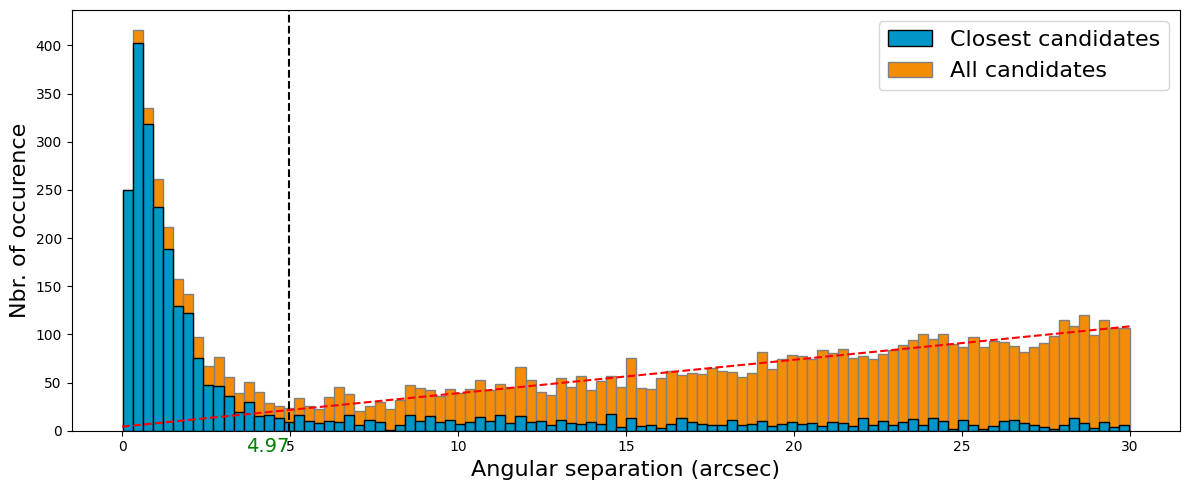

In [6]:
common_bin=100
subset1=xmm_crossmatch_all["angDist"]
subset2=xmm_crossmatch_best["angDist"]

                                #Les histo
    
plt.figure(figsize=(12,5))

hist_best=plt.hist(subset2,bins=common_bin,color='#0096c7',label='Closest candidates',edgecolor='black',zorder=1)
hist_all=plt.hist(subset1,bins=common_bin,color='#f48c06',label='All candidates',edgecolor='grey',zorder=0)

                                #Tendency part

x=0.5 *(hist_all[1][1:] + hist_all[1][:-1]) #Milieu des bins
#plt.scatter(x[x>5],hist_all[0][x>5])
p= np.polyfit(x[x>7],hist_all[0][x>7],deg=1) #Regression lineaire
linspace=np.linspace(0,30,2)


                                 #Calcul pourcentage
i=1
seuil=10
percent=np.sum(p[0]*x+p[1])/np.sum(hist_all[0]) *100
print(percent)
while percent>seuil:
    percent=np.sum(p[0]*x[x<=x[-i]]+p[1])/np.sum(hist_all[0][x<=x[-i]]) *100
    if percent>seuil:
        i+=1

# print(round(percent,2),"% of contaminent if x=",x[-i])
# print("Jaune:",len(xmm_crossmatch_all[xmm_crossmatch_all["angDist"]<x[-i]]))
# print("Bleu:",len(xmm_crossmatch_best[xmm_crossmatch_best["angDist"]<x[-i]]))
# print("Crossmatch quality done")
#plt.savefig("./Images/Cross_quali.png")

#Pour le diapo



plt.plot(linspace ,  p[0]*linspace + p[1]  , color='red' , linestyle='dashed')
plt.text(x[-i],-7,f"{round(x[-i],2)}",ha='right',va='top',fontsize=14,color='green')
plt.axvline(x[-i],color='black',linestyle='dashed')
plt.xlabel("Angular separation (arcsec)",fontsize=16)
plt.ylabel("Nbr. of occurence",fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("./Images/Cross_quali.png")
plt.savefig("./Images/Cross_quali.pdf")

In [7]:
xmm_crossmatched=crossmatch_gaia(sub_xmm,'best',x[-i])       #Valeur mise a la main
xmm_crossmatched.write('./Tables/xmm_crossmatched.fits',format='fits',overwrite=True)

In [8]:
print(len(xmm_crossmatched))
print(round(len(xmm_crossmatched)/len(sub_xmm)*100),"% of XMM data having CTPs in Gaia")

1946
63 % of XMM data having CTPs in Gaia


# Partie mask

In [9]:
mask_pm_gaia=(np.isnan(sub_gaia["pmRA"]) != True) & (np.isnan(sub_gaia["pmDE"]) != True)
mask_updated=(np.isnan(xmm_crossmatched["PM"]) != True)
mask_gaia_updated=(np.isnan(sub_gaia["pmRA"]) != True) & (np.isnan(sub_gaia["pmDE"]) != True)

# Partie quality

## Partie Plx

Quality on parallaxe done, keeping:
0 < relative error < 0.1
83 % kept since the begining
24 % kept since the begining for Gaia


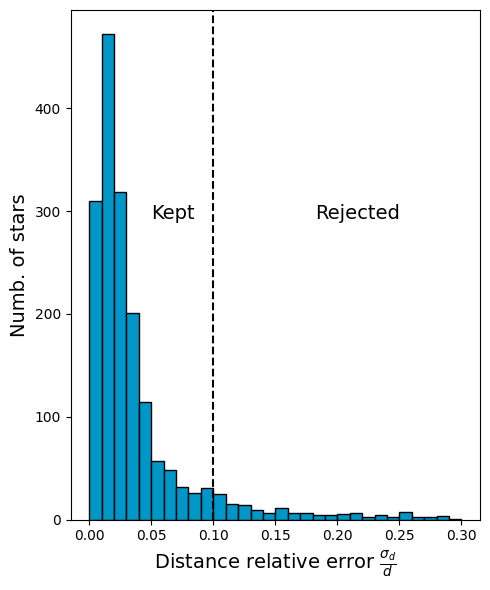

In [10]:
# plt.figure(figsize=(5,6))
cut=0.1

subset=xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"]

mask_e_plx= (subset < cut) & (subset>0)
mask_updated= mask_updated & (mask_e_plx)
print(f"Quality on parallaxe done, keeping:\n0 < relative error < {cut}")
print(round((len(xmm_crossmatched[mask_updated])/(len(xmm_crossmatched)))*100),"% kept since the begining")

# #On cut aussi sur Gaia
subset=sub_gaia["e_Plx"]/sub_gaia["Plx"]
mask_gaia_updated=mask_gaia_updated & (subset < cut) & (subset>0)
print(round((len(sub_gaia[mask_gaia_updated])/(len(sub_gaia)))*100),"% kept since the begining for Gaia")

#Error on Distance
e_d=1/xmm_crossmatched["Plx"] * 1000 *(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"])
bins=np.logspace(-2,7,20)
test=e_d/(1/xmm_crossmatched["Plx"] * 1000)

plt.figure(figsize=(5,6))

plt.hist(test,range=[0,0.3],bins=30,edgecolor='black',color="#0096c7")

plt.xlabel(r"Distance relative error $\frac{\sigma_{d}}{d}$", fontsize=14)
plt.ylabel("Numb. of stars", fontsize=14)

plt.text(0.70,0.6,"Rejected",transform=plt.gca().transAxes , ha='center' , va='center', fontsize=14)
plt.text(0.25,0.6 ,"Kept",transform=plt.gca().transAxes , ha='center' , va='center', fontsize=14)
plt.axvline(0.1,color='black',linestyle='dashed')
plt.tight_layout()
plt.savefig("Images/distance_relative_error.pdf")

## Partie PM

Quality on parallaxe done, keeping:
relative error < 0.2
78 % kept since the begining
23 % kept since the begining for Gaia


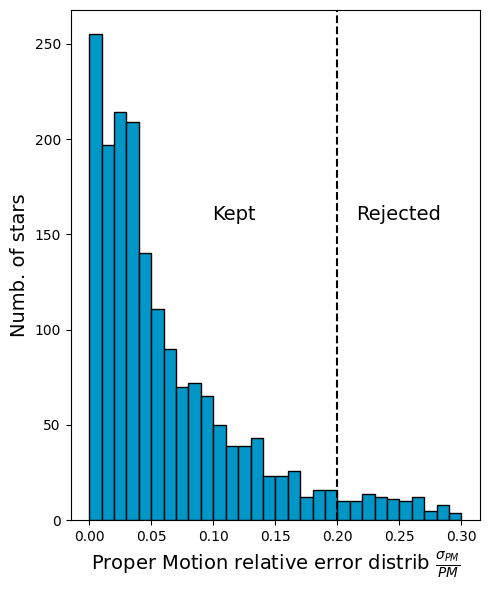

In [11]:
plt.figure(figsize=(5,6))
cut=0.2

subset=np.sqrt(xmm_crossmatched["e_pmDE"]**2+xmm_crossmatched["e_pmRA"]**2)/xmm_crossmatched["PM"]

plt.hist(subset,bins=30,range=[0,0.3],color="#0096c7",edgecolor='black')

plt.xlabel(r"Proper Motion relative error distrib $\frac{\sigma_{PM}}{PM}$", fontsize=14)
plt.ylabel("Numb. of stars", fontsize=14)
plt.text(0.80,0.6,"Rejected",transform=plt.gca().transAxes , ha='center' , va='center', fontsize=14)
plt.text(0.4,0.6 ,"Kept",transform=plt.gca().transAxes , ha='center' , va='center', fontsize=14)
plt.axvline(cut,color='black',linestyle='dashed')
plt.tight_layout()
plt.savefig("Images/pm_relative_error.pdf")

mask_pm= (subset < cut)
mask_updated= mask_updated & mask_pm
print(f"Quality on parallaxe done, keeping:\nrelative error < {cut}")
print(round((len(xmm_crossmatched[mask_updated])/(len(xmm_crossmatched)))*100),"% kept since the begining")



#On cut aussi sur Gaia
subset=np.sqrt(sub_gaia["e_pmDE"]**2+sub_gaia["e_pmRA"]**2)/sub_gaia["PM"]
mask_gaia_updated=mask_gaia_updated & (subset < cut)
print(round((len(sub_gaia[mask_gaia_updated])/(len(sub_gaia)))*100),"% kept since the begining for Gaia")



## Partie Flux excess A changer ? (Regarde les #)

68 % kept since the begining
20 % kept since the begining for Gaia


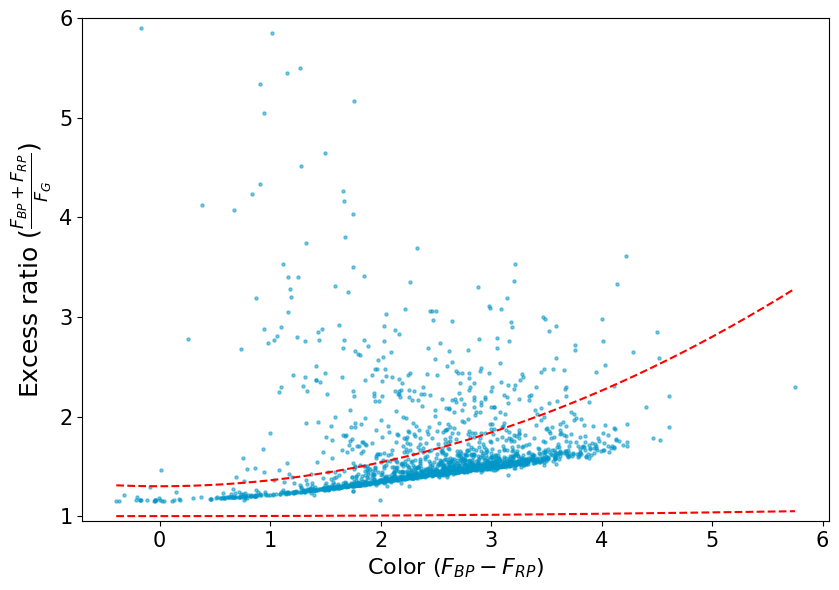

In [80]:
x=xmm_crossmatched["FG"]
y=xmm_crossmatched["FBP"]+xmm_crossmatched["FRP"]
E=y/x
soustraction=xmm_crossmatched["BP-RP"]

g=1+0.0015*soustraction**2
d=1.3+0.06*soustraction**2

x=np.linspace(np.min(soustraction),np.max(soustraction),1000)



plt.figure(figsize=(8.5,6))
plt.xlabel(r"Color ($F_{BP}-F_{RP})$",fontsize=16)
plt.ylabel(r"Excess ratio ($ \frac{F_{BP}+F_{RP}}{F_G}$)",fontsize=18)

plt.scatter(soustraction,E,c="#0096c7",s=5,alpha=0.5)

#plt.text(0.5,0.1,"Outside the two red dotted line: Rejected", fontsize=10,transform=plt.gca().transAxes , ha='center' , va='center')
y1=1+0.0015*x**2
y2=1.3+0.06*x**2
plt.plot(x,y1,color='red',linestyle='dashed')
plt.plot(x,y2,color='red',linestyle='dashed')
plt.ylim(0.95,6)

mask_flux_excess= (E > g) & (E <d)
mask_updated= mask_updated &(mask_flux_excess)
print(round((len(xmm_crossmatched[mask_updated])/(len(xmm_crossmatched)))*100),"% kept since the begining")
plt.tight_layout()
plt.savefig("Images/Flux_excess_ratio.pdf")
plt.savefig("Images/Flux_excess_ratio.png")

#On cut aussi sur Gaia
x=sub_gaia["FG"]
y=sub_gaia["FBP"]+sub_gaia["FRP"]
E=y/x
soustraction=sub_gaia["BP-RP"]

g=1+0.0015*soustraction**2
d=1.3+0.06*soustraction**2

mask_gaia_updated=mask_gaia_updated & (E > g) & (E <d)
print(round((len(sub_gaia[mask_gaia_updated])/(len(sub_gaia)))*100),"% kept since the begining for Gaia")


## Quality elimination %

In [13]:
print(round((len(xmm_crossmatched[mask_updated])/(len(xmm_crossmatched)))*100),"% kept since the begining")
print(round((len(xmm_crossmatched[mask_updated])/(len(sub_xmm)))*100),"% kept since the begining")
print(len(xmm_crossmatched[mask_updated]))

68 % kept since the begining
43 % kept since the begining
1323


# Partie members criteria

## Parallaxe distirbution study

60.33 % kept since the begining
88.74 % kept after the quality criteria
9.77 % kept since the begining
49.59 % kept after the quality criteria
distance min= 325 pc | Distance max= 450 pc
Distance mediane= 3.0 pc


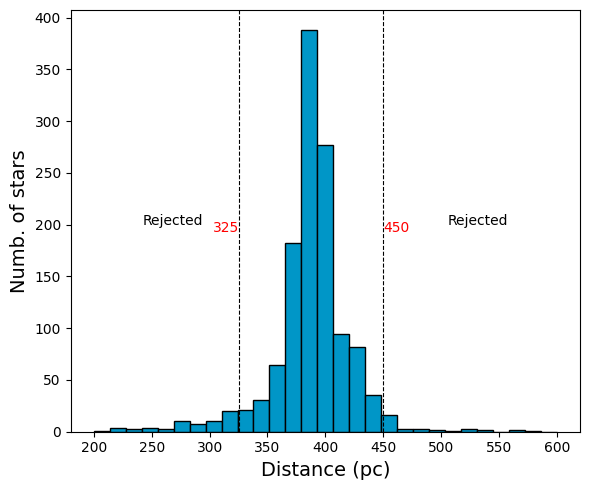

In [14]:
plt.figure(figsize=(6,5))
bins=np.linspace(200,600,30)

ax2=plt.subplot(1,1,1)
#Plot des distances en pc
cut_haut=450
cut_bas=325
subset=1/xmm_crossmatched["Plx"][mask_updated] *1000

h , edges , _ = ax2.hist(subset,bins=bins,color="#0096c7",edgecolor='black')

ax2.axvline(cut_haut,c='black',linestyle='dashed',linewidth=0.8)
ax2.axvline(cut_bas,c='black',linestyle='dashed',linewidth=0.8)
ax2.set_xlabel("Distance (pc)", fontsize=14)
ax2.set_ylabel("Numb. of stars", fontsize=14)

ax2.text(0.2,0.5,"Rejected", fontsize=10,transform=plt.gca().transAxes , ha='center' , va='center')
ax2.text(0.8,0.5,"Rejected", fontsize=10,transform=plt.gca().transAxes , ha='center' , va='center')

mask_member_plx= (subset>cut_bas) & (subset<cut_haut) #Contre intuitif pck inverse des distances
mask_member_updated= mask_member_plx #Creation du second mask

ax2.text(0.28,0.5,cut_bas,fontsize=10, transform=plt.gca().transAxes , ha='left' , va='top',color='red')
ax2.text(0.64,0.5,cut_haut,fontsize=10, transform=plt.gca().transAxes , ha='center' , va='top',color='red')

plt.tight_layout()
plt.savefig("Images/Distance_criteria.pdf")


print(round((len(xmm_crossmatched[mask_updated][mask_member_updated])/(len(xmm_crossmatched)))*100,2),"% kept since the begining")
print(round((len(xmm_crossmatched[mask_updated][mask_member_updated])/(len(xmm_crossmatched[mask_updated])))*100,2)
      ,"% kept after the quality criteria")

#########################################################

#On cut aussi sur Gaia
subset=1/sub_gaia["Plx"][mask_gaia_updated] *1000
mask_gaia_member_updated=(subset<cut_haut) & (subset>cut_bas) #Creation du second mask

print(round((len(sub_gaia[mask_gaia_updated][mask_gaia_member_updated])/(len(sub_gaia)))*100,2),"% kept since the begining")
print(round((len(sub_gaia[mask_gaia_updated][mask_gaia_member_updated])/(len(sub_gaia[mask_gaia_updated])))*100,2)
      ,"% kept after the quality criteria")

print("distance min=",round(cut_bas,0),"pc | Distance max=",round(cut_haut,0),"pc")
print("Distance mediane=",round(1/np.median(subset) *1000,0),"pc")






## Proper motion analysis of the crossmatched catalog

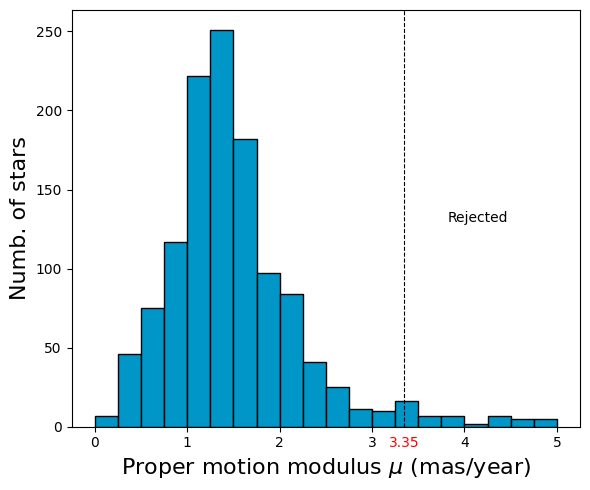

Proper motion analysis of the crossmatched catalog done. only PM < 3.35 mas/year kept.
57.65673175745118 % kept since the begining
84.80725623582767 % kept since criteria cut


In [15]:
plt.figure(figsize=(6,5))
subset=xmm_crossmatched["PM"][mask_updated]
cut=3.35
#x,p,mean,std=Gaussian_fit(0,4,subset)

h,_,_=plt.hist(subset,bins=20,range=[0,5],color="#0096c7",edgecolor='black')

p=p*np.max(h)/np.max(p)
#plt.plot(x,p,color='black')
#plt.title("Fit Values: mean:{:.2f} | standard deviation:{:.2f}".format(mean, std))
plt.ylabel("Numb. of stars", fontsize=16)
plt.xlabel("Proper motion modulus $\mu$ (mas/year)", fontsize=16)
plt.axvline(3.35,c='black',linestyle='dashed',linewidth=0.8)
plt.text(0.8,0.5,"Rejected", fontsize=10,transform=plt.gca().transAxes , ha='center' , va='center')
plt.text(cut,-10,cut,fontsize=10, ha='center' , va='center',color='red')
plt.tight_layout()
plt.savefig("Images/PM_distrib.pdf")
plt.show()
mask_member_updated=mask_member_updated & (subset< cut)
print(f"Proper motion analysis of the crossmatched catalog done. only PM < {cut} mas/year kept.")



print((len(xmm_crossmatched[mask_updated][mask_member_updated])/(len(xmm_crossmatched)))*100,"% kept since the begining")
print((len(xmm_crossmatched[mask_updated][mask_member_updated])/(len(xmm_crossmatched[mask_updated])))*100,"% kept since criteria cut")
#On cut aussi sur Gaia
subset=sub_gaia["PM"][mask_gaia_updated]
mask_gaia_member_updated=mask_gaia_member_updated & (subset< 3.35)


### Creation of a Distance column

In [16]:
try:
    xmm_crossmatched.add_column(1/xmm_crossmatched["Plx"] *1000 , name="Distance")
    xmm_crossmatched.add_column(1/xmm_crossmatched["Plx"] * 1000 *(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"]), name="e_Distance")
except:
    xmm_crossmatched.replace_column("Distance",1/xmm_crossmatched["Plx"] *1000)
    xmm_crossmatched.replace_column("e_Distance",1/xmm_crossmatched["Plx"] * 1000 *(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"]))  

In [17]:
print(round((len(xmm_crossmatched[mask_updated][mask_member_updated])/(len(xmm_crossmatched[mask_updated])))*100),"% kept since criteria cut")
print(len(xmm_crossmatched[mask_updated]))
print(round((len(xmm_crossmatched[mask_updated][mask_member_updated]))))

85 % kept since criteria cut
1323
1122


# Criteria results

In [18]:
xmm_crossmatched_orion=xmm_crossmatched[mask_updated][mask_member_updated]
xmm_crossmatched_orion=xmm_crossmatched_orion.group_by("Source_1")
print(f"At the end, {round(len(xmm_crossmatched_orion)/len(xmm_crossmatched)*100)} % candidate with good error AND in the cloud\nGiving {len(xmm_crossmatched_orion)} candidates")

gaia_cleanuped=sub_gaia[mask_gaia_updated][mask_gaia_member_updated]
print(f"At the end, {round(len(gaia_cleanuped)/len(sub_gaia)*100)} % candidate with good error AND in the cloud\nGiving {len(gaia_cleanuped)} candidates")


try:
    gaia_cleanuped.add_column(1/gaia_cleanuped["Plx"] *1000 , name="Distance")
    gaia_cleanuped.add_column(1/gaia_cleanuped["Plx"] * 1000 *(gaia_cleanuped["e_Plx"]/gaia_cleanuped["Plx"]), name="e_Distance")
except:
    gaia_cleanuped.replace_column("Distance",1/gaia_cleanuped["Plx"] *1000)
    gaia_cleanuped.replace_column("e_Distance",1/gaia_cleanuped["Plx"] * 1000 *(gaia_cleanuped["e_Plx"]/gaia_cleanuped["Plx"]))  




At the end, 58 % candidate with good error AND in the cloud
Giving 1122 candidates
At the end, 8 % candidate with good error AND in the cloud
Giving 2041 candidates


In [19]:
try:
    xmm_crossmatched.add_column(1/xmm_crossmatched["Plx"] *1000 , name="Distance")
    xmm_crossmatched.add_column(1/xmm_crossmatched["Plx"] * 1000 *(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"]), name="e_Distance")
except:
    xmm_crossmatched.replace_column("Distance",1/xmm_crossmatched["Plx"] *1000)
    xmm_crossmatched.replace_column("e_Distance",1/xmm_crossmatched["Plx"] * 1000 *(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"]))  
    

# Study of the subset

## Skyview

In [20]:
'''
from ipyaladin import Aladin

aladin = Aladin(
    survey="http://skies.esac.esa.int/XMM-Newton/EPIC-RGB",
    show_coo_grid=False,
    target="orion",
    coo_frame="galactic",
    fov=40,
    reticle_color="#ff89ff"
)
aladin
'''
print("")

In [21]:
print(len(sub_xmm))
print(len(sub_gaia))
#print(len(xmm_crossmatched))
print(len(xmm_crossmatched_orion))
#print(len(gaia_cleanuped))

'''
subset1=1/gaia_cleanuped["Plx"] *1000
bins=np.linspace(100,1000,50)
_=plt.hist(subset1,bins=bins,fill=False,edgecolor='blue')

subset2=1/sub_gaia["Plx"] *1000
_=plt.hist(subset2,bins=bins,fill=False,edgecolor='orange')
'''
pass

3089
26416
1122


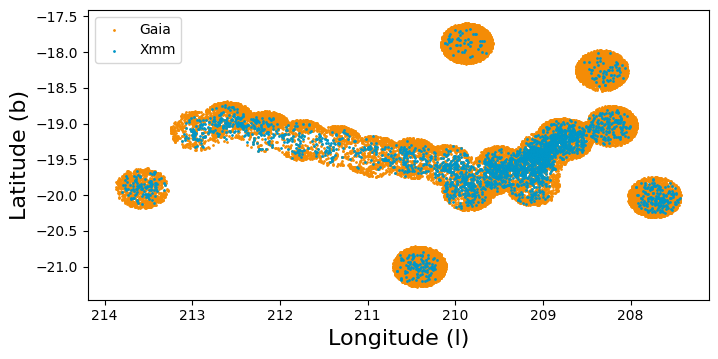

Skyview done


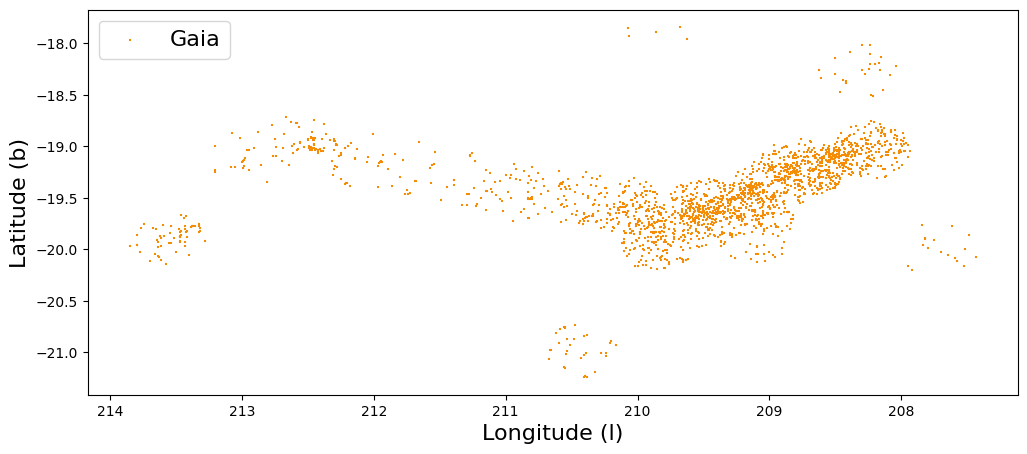

Skyview of the crossmatched catalog done


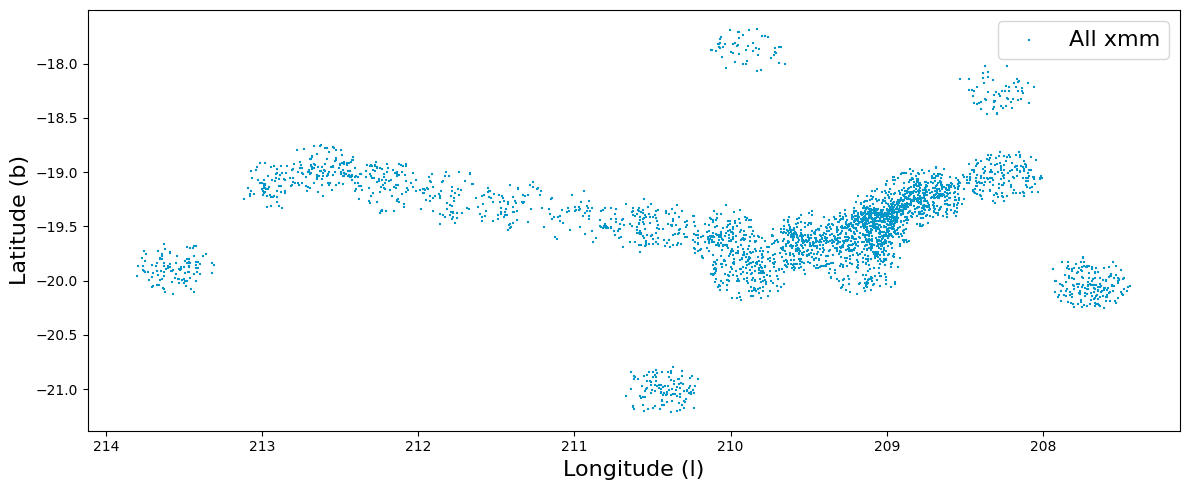

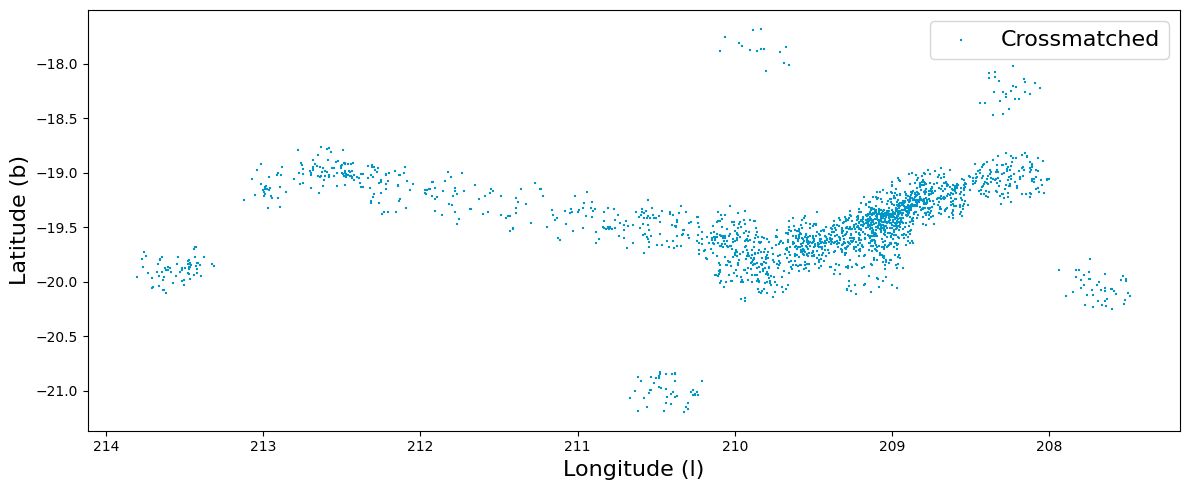

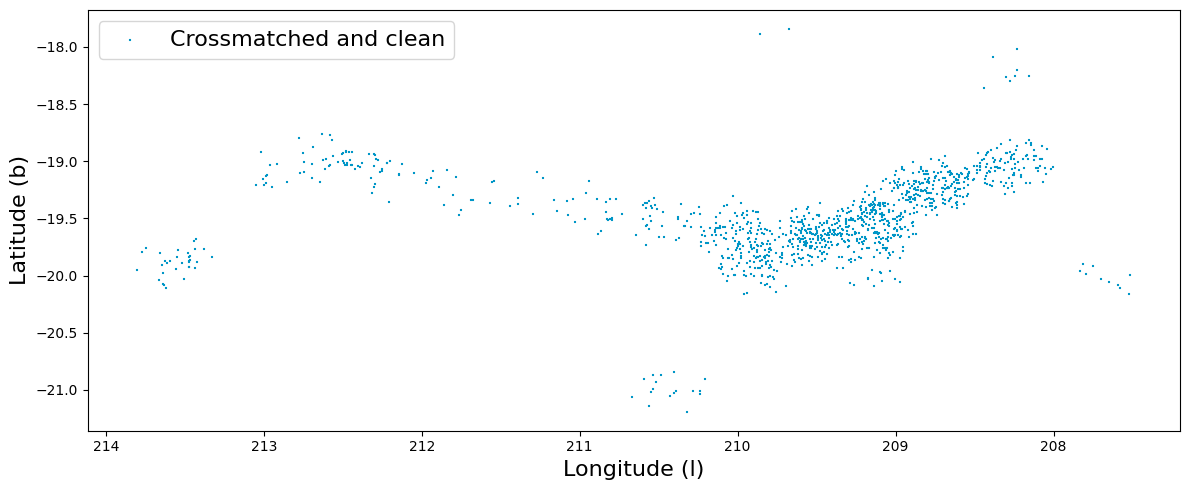

In [22]:
hauteur=int(739/2)/100
largeur=729/100
plt.figure(figsize=(largeur,hauteur))

plt.scatter(sub_gaia["glon"],sub_gaia["glat"],zorder=0,color='#f48c06',label='Gaia',s=1)
plt.scatter(sub_xmm["glon"],sub_xmm["glat"],zorder=1,color='#0096c7',label='Xmm',s=1)
plt.xlabel("Longitude (l)", fontsize=16)
plt.ylabel("Latitude (b)", fontsize=16)
plt.gca().invert_xaxis()
plt.legend()

plt.tight_layout()
plt.savefig("Images/Glon_Glat.pdf")
#plt.savefig("Images/Glon_Glat_all.png")

#plt.title("Before cleanup")
#plt.savefig("Images/skyview.pdf",format='pdf')
#plt.close()
plt.show() # pas dans le script
print("Skyview done")

plt.figure(figsize=(12,5))

#plt.scatter(sub_gaia["glon"],sub_gaia["glat"],zorder=0,color='#f48c06',label='Gaia (orange)',s=0.01)
#plt.scatter(xmm_crossmatched_orion["glon"],xmm_crossmatched_orion["glat"],zorder=1,color='#0096c7',label='Xmm',s=1,marker="x")
plt.scatter(gaia_cleanuped["glon"],gaia_cleanuped["glat"],zorder=0,color='#f48c06',label='Gaia',s=1,marker="+")
plt.xlabel("Longitude (l)", fontsize=16)
plt.ylabel("Latitude (b)", fontsize=16)
plt.gca().invert_xaxis()
plt.legend(fontsize=16)
#plt.title("After cleanup")

plt.show() # pas dans le script
print("Skyview of the crossmatched catalog done")

plt.figure(figsize=(12,5))

plt.scatter(sub_xmm["glon"],sub_xmm["glat"],zorder=0,color='#0096c7',label='All xmm',s=1,marker="+")
plt.xlabel("Longitude (l)", fontsize=16)
plt.ylabel("Latitude (b)", fontsize=16)
plt.gca().invert_xaxis()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("Images/All_xmm.png")

plt.figure(figsize=(12,5))

plt.scatter(xmm_crossmatched["glon"],xmm_crossmatched["glat"],zorder=0,color='#0096c7',label='Crossmatched',s=1,marker="+")
plt.xlabel("Longitude (l)", fontsize=16)
plt.ylabel("Latitude (b)", fontsize=16)
plt.gca().invert_xaxis()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("Images/Cross_xmm.png")

plt.figure(figsize=(12,5))

plt.scatter(xmm_crossmatched_orion["glon"],xmm_crossmatched_orion["glat"],zorder=0,color='#0096c7',label='Crossmatched and clean',s=1,marker="+")
plt.xlabel("Longitude (l)", fontsize=16)
plt.ylabel("Latitude (b)", fontsize=16)
plt.gca().invert_xaxis()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("Images/Cross_clean_xmm.png")



## pmRA vs pmDE

Text(0, 0.5, 'pmDEC (mas/year)')

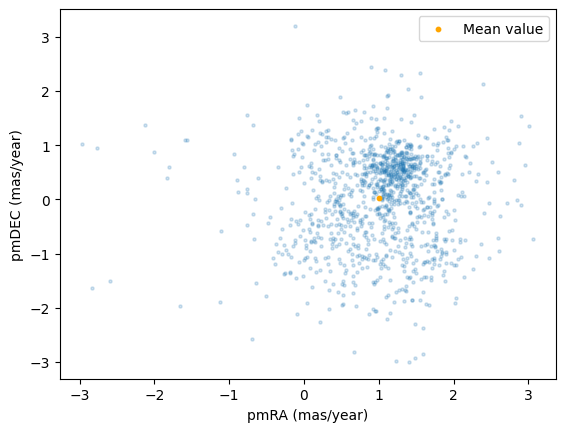

In [23]:
subset1=xmm_crossmatched_orion['pmRA']
subset2=xmm_crossmatched_orion['pmDE']
plt.scatter(subset1,subset2,marker="o",alpha=0.2,s=5,zorder=0)
plt.scatter(np.mean(subset1),np.mean(subset2),color='orange',label='Mean value',s=10,zorder=1)
plt.legend()
plt.xlabel("pmRA (mas/year)")
plt.ylabel("pmDEC (mas/year)")
#plt.title(f"Cut criteria: $|\mu|<3.5$")
#plt.savefig("Images/crossmatched_PM_plot.pdf",format='pdf')
#plt.close()

## Mediane de longitude vs distance 

Text(0.5, 1.0, 'Shaded area: 1 and 2 sigma criteria')

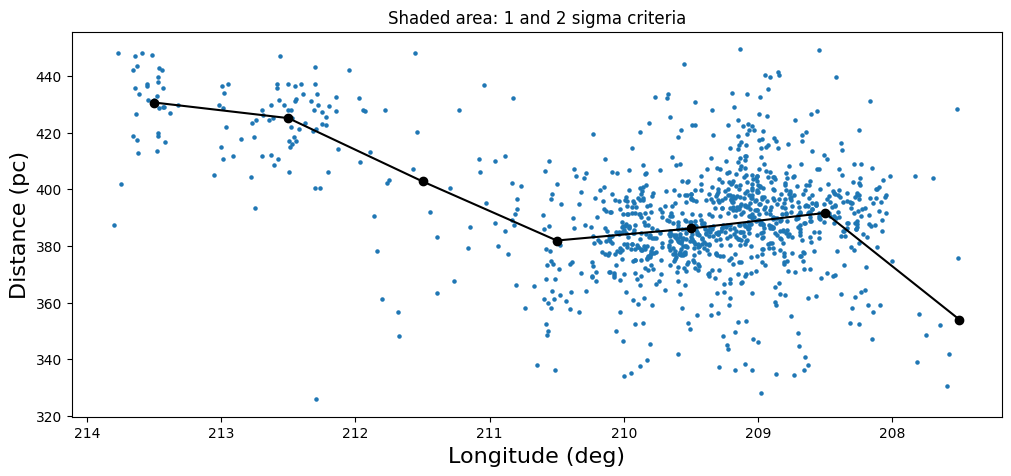

In [24]:
plt.figure(figsize=(12,5))
x=xmm_crossmatched["glon"][mask_updated][mask_member_updated]
y=1/xmm_crossmatched["Plx"][mask_updated][mask_member_updated] *1000
median,std,mini,maxi=Median_scatter(x,y,1)
X=np.linspace(mini,maxi,len(median))
plt.plot(X,median,zorder=1,color='black')
plt.scatter(X,median,zorder=1,color='black')

#plt.plot(X,median + std,zorder=1,color='orange')
#plt.plot(X,median - std,zorder=1,color='orange')
#plt.fill_between(X,median + std,median - std,alpha=0.2,color='orange')
#plt.fill_between(X,median + 2*std,median - 2*std,alpha=0.2,color='orange')
#plt.fill_between(X,median + 3*std,median - 3*std,alpha=0.2,color='orange')

plt.scatter(x,y,zorder=0,s=5)
plt.xlabel("Longitude (deg)",fontsize=16)
plt.ylabel("Distance (pc)",fontsize=16)
plt.gca().invert_xaxis()
plt.title("Shaded area: 1 and 2 sigma criteria")
#plt.savefig("Images/median_longitude_vs_distance.pdf",format='pdf')
#plt.close()

## Colormap tentative distance

Colormap of distance done


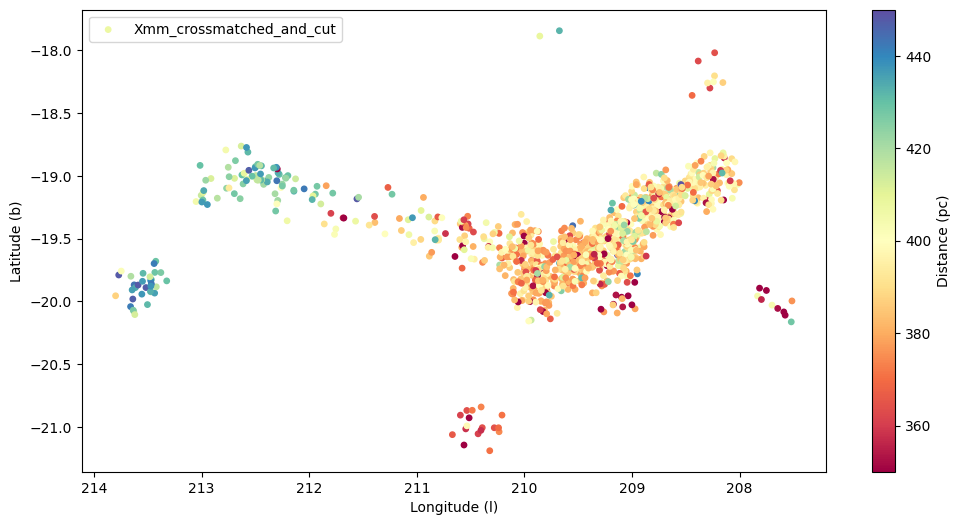

In [25]:
x=xmm_crossmatched_orion["glon"]
y=xmm_crossmatched_orion["glat"]
z=xmm_crossmatched_orion["Distance"]
plt.figure(figsize=(12,6))
plt.scatter(x,y,c=z,cmap='Spectral',label='Xmm_crossmatched_and_cut',s=15,vmin=350,vmax=450)
plt.xlabel("Longitude (l)")
plt.ylabel("Latitude (b)")
plt.colorbar(label="Distance (pc)")
plt.gca().invert_xaxis()
plt.legend(loc='upper left')
#plt.savefig("Images/crossmatched_colormap_distance_.pdf",format='pdf')
#plt.close()
print("Colormap of distance done")

57 % for crossmatched catalogue
53 % for Gaia catalogue
None


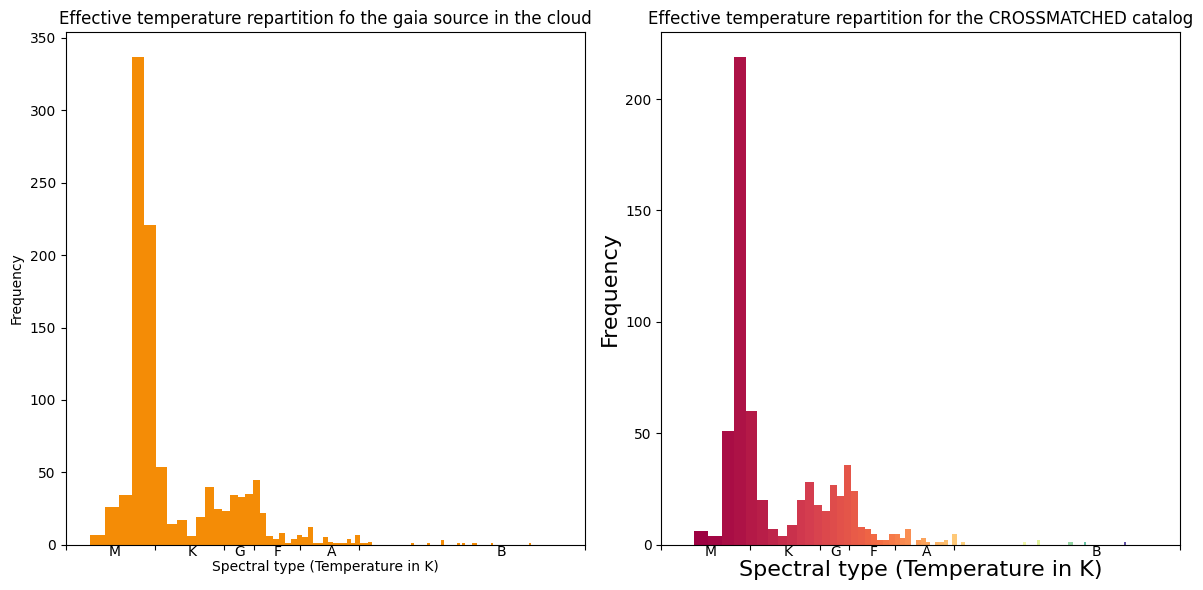

In [26]:
common_bins=100
plt.figure(figsize=(12,6))
subset=gaia_cleanuped["Teff"]
plt.subplot(1,2,1)

un=plt.hist(subset,bins=common_bins,color='#f48c06')

location_label=[2400,3700,5200,6000,7500,10000,30000]
label=['' for i in range(7)]
spec_label=['M','K','G','F','A','B','O']
plt.xscale('log')
plt.minorticks_off()
plt.xlabel("Spectral type (Temperature in K)")
plt.ylabel("Frequency")
plt.title("Effective temperature repartition fo the gaia source in the cloud")
plt.xticks(location_label,label)
for i in range(len(location_label)-1):
    plt.text((location_label[i]+location_label[i+1])/2,0,spec_label[i],ha='center',va='top')
plt.tight_layout()


subset=xmm_crossmatched_orion["Teff"]
plt.subplot(1,2,2)

deux=plt.hist(subset,bins=common_bins)

colors=plt.cm.get_cmap('Spectral')(np.linspace(0, 1, common_bins))
for i in range(common_bins):
    deux[2][i].set_facecolor(colors[i])
location_label=[2400,3700,5200,6000,7500,10000,30000]
label=['' for i in range(7)]
spec_label=['M','K','G','F','A','B','O']
plt.xscale('log')
plt.minorticks_off()
plt.xlabel("Spectral type (Temperature in K)",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Effective temperature repartition for the CROSSMATCHED catalog")
plt.xticks(location_label,label)
for i in range(len(location_label)-1):
    plt.text((location_label[i]+location_label[i+1])/2,0,spec_label[i],ha='center',va='top')
plt.tight_layout()

#Pour l'oral
print(round(len(xmm_crossmatched_orion["Teff"][xmm_crossmatched_orion["Teff"]>0])/len(xmm_crossmatched_orion) *100)
      ,"% for crossmatched catalogue")
print(print(round(len(gaia_cleanuped["Teff"][gaia_cleanuped["Teff"]>0])/len(gaia_cleanuped) *100)
      ,"% for Gaia catalogue"))





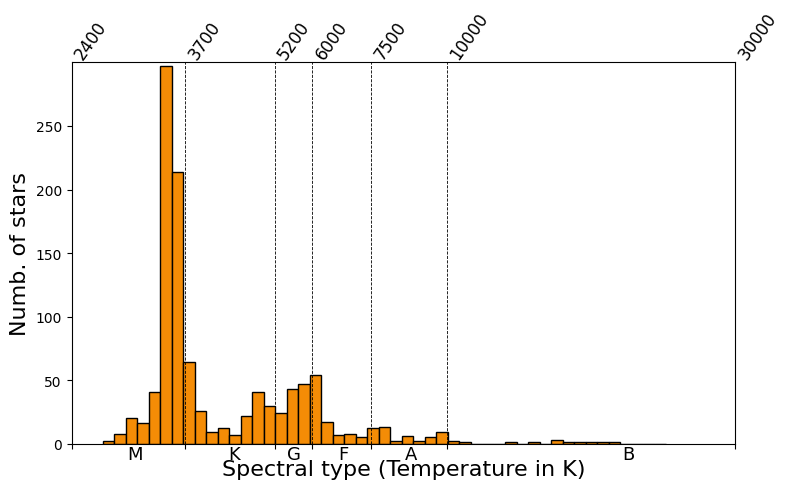

In [27]:
plt.figure(figsize=(8,5))
subset=gaia_cleanuped["Teff"]
bins=np.logspace(np.log10(np.nanmin(subset)),np.log10(np.nanmax(subset)),50)

un=plt.hist(subset,bins=bins,color='#f48c06',edgecolor='black')

location_label=np.array([2400,3700,5200,6000,7500,10000,30000])
mid_label=[(location_label[i]+location_label[i+1])/2 for i in range(len(location_label)-1)]
label=['' for i in range(7)]
spec_label=['M','K','G','F','A','B','O']
plt.xscale('log')
plt.minorticks_off()
plt.xlabel("Spectral type (Temperature in K)",fontsize=16)
plt.ylabel("Numb. of stars", fontsize=16)
#plt.title("Effective temperature repartition fo the gaia source in the cloud")
plt.xticks(location_label,label)
top=np.max(un[0])*1.01
for i in range(len(mid_label)):
    plt.text(mid_label[i],-1,spec_label[i],ha='center',va='top',fontsize=13)
    plt.text(location_label[i],top,location_label[i],ha='left',va='bottom',fontsize=12,rotation=55)
    plt.axvline(location_label[i+1],c='black',linestyle='dashed',linewidth=0.6)
plt.text(location_label[-1],top,location_label[-1],ha='left',va='bottom',fontsize=12,rotation=55)
plt.ylim(0,top)
plt.tight_layout()
plt.savefig("Images/Teff_Distrib.pdf")

In [28]:
#display(gaia_cleanuped)
print(round(len(gaia_cleanuped["AG"][gaia_cleanuped["AG"]>0])/len(gaia_cleanuped["AG"]) *100,2),"% Kept for gaia")

a=len(xmm_crossmatched_orion["AG"][xmm_crossmatched_orion["AG"]>0])
print(round(a/len(xmm_crossmatched_orion["AG"]) *100,2),"% Kept for crossmatched catalog")
print(f"There is {a} sources with a Teff referenced for the crossnatched catalog")





52.82 % Kept for gaia
56.77 % Kept for crossmatched catalog
There is 637 sources with a Teff referenced for the crossnatched catalog


## Seeking bias if we take only data with Teff (and so Ag)

In [29]:


def Plot_Comparaison(data1:list,data2:list,BIN,labelX,save=0,name=""): #data contient la liste et le label [donnee,label]
    hist1,hist2,ratio,errors,poserrors=Comparaison(data1[0],data2[0],BIN)
    plt.figure(figsize=(10,5))
    ax1=plt.subplot(2,1,1)
    ax1.stairs(hist1[0],hist1[1],label=data1[1],color='orange')
    ax1.stairs(hist2[0],hist2[1],label=data2[1],color='blue')
    ax1.set_ylabel("Numb. of stars", fontsize=16)
    ax1.legend(fontsize=16,loc="upper left")

    ax2=plt.subplot(2,1,2,sharex=ax1)
    ax2.stairs(ratio,hist1[1],color='red')
    ax2.errorbar(poserrors,ratio,yerr=errors,linestyle="",c="black")
    ax2.set_ylim(0,1.1)
    ax2.set_xlabel(labelX, fontsize=16)
    ax2.set_ylabel("Ratio",fontsize=16)
    plt.setp(ax1.get_xticklabels(), visible=False)
    if save==1:
        while name=="":
            name=str(input("Select name of the file:\n"))
        plt.savefig(f"/home/thomas/Documents/0_Stage/Code/Images/{name}.pdf")

/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: divide by zero encountered in divide
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])
/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: invalid value encountered in multiply
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])
/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: divide by zero encountered in divide
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])
/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: invalid value encountered in multiply
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])


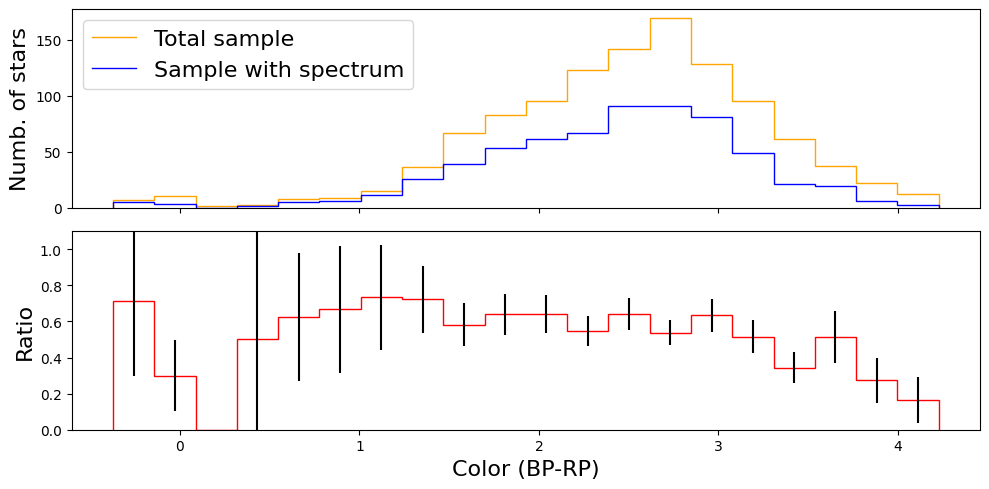

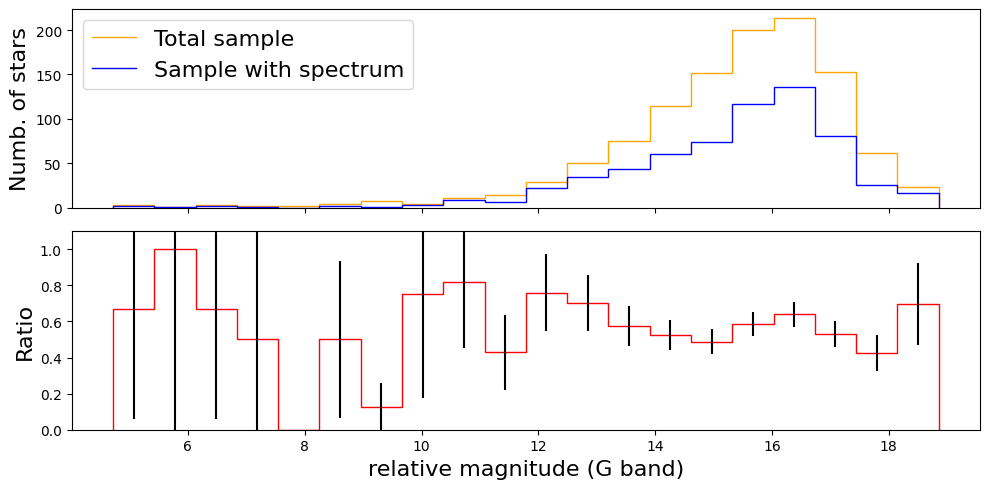

In [30]:
# data1=gaia_cleanuped["Gmag"]
# data2=gaia_cleanuped["Gmag"][gaia_cleanuped["Teff"]>0]

# Plot_Comparaison([data1,"Gaia"],[data2,"Gaia with Teff"],20,"Magnitude")

# plt.tight_layout()
# plt.savefig("Images/Ratio_T_gaia.pdf")

data1=xmm_crossmatched_orion["BP-RP"]
data2=xmm_crossmatched_orion["BP-RP"][xmm_crossmatched_orion["Teff"]>0]

Plot_Comparaison([data1,"Total sample"],[data2,"Sample with spectrum"],20,"Color (BP-RP)")
plt.tight_layout()
plt.savefig("Images/Ratio_Color.pdf")

data1=xmm_crossmatched_orion["Gmag"]
data2=xmm_crossmatched_orion["Gmag"][xmm_crossmatched_orion["Teff"]>0]

Plot_Comparaison([data1,"Total sample"],[data2,"Sample with spectrum"],20,"relative magnitude (G band)")
plt.tight_layout()
plt.savefig("Images/Ratio_Magnitude.pdf")

/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: divide by zero encountered in divide
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])
/home/thomas/Documents/0_Stage/Code/DEF.py:165: RuntimeWarning: invalid value encountered in multiply
  errors=hist2[0]/hist1[0]*np.sqrt(1/hist2[0] + 1/hist1[0])
/home/thomas/Documents/0_Stage/Code/DEF.py:166: RuntimeWarning: divide by zero encountered in divide
  ratio=hist2[0]/hist1[0]
/home/thomas/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3593: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


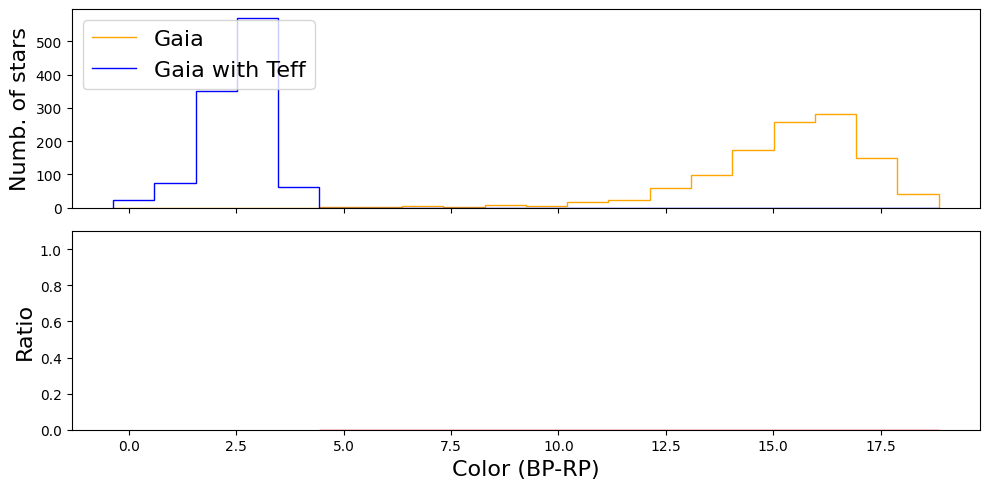

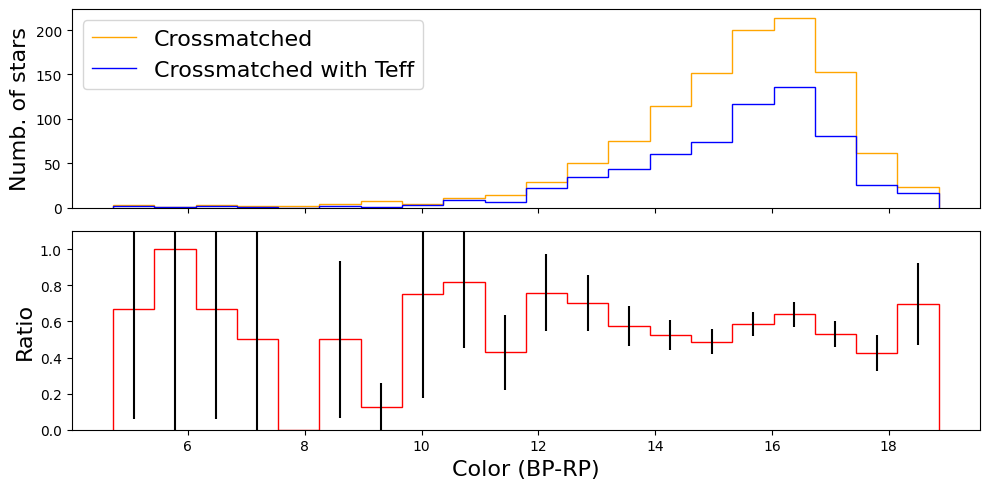

In [31]:
### data1=gaia_cleanuped["BP-RP"]
data2=gaia_cleanuped["BP-RP"][gaia_cleanuped["Teff"]>0]

Plot_Comparaison([data1,"Gaia"],[data2,"Gaia with Teff"],20,"Color (BP-RP)")

plt.tight_layout()
plt.savefig("Images/Ratio_T_gaia.png")

data1=xmm_crossmatched_orion["Gmag"]
data2=xmm_crossmatched_orion["Gmag"][xmm_crossmatched_orion["Teff"]>0]

Plot_Comparaison([data1,"Crossmatched"],[data2,"Crossmatched with Teff"],20,"Color (BP-RP)")
plt.tight_layout()
plt.savefig("Images/Ratio_T_xmm.png")

# Adding a column Gabs, Gabs_corrected and BP-RP_corrected

## Incertitude de Gabs

In [32]:
Grelat=xmm_crossmatched_orion["Gmag"]
Gabs=Grelat-5*np.log10(xmm_crossmatched_orion["Distance"])+5

e_Gmag=xmm_crossmatched_orion["e_Gmag"]
e_d=xmm_crossmatched_orion["e_Distance"]
d=xmm_crossmatched_orion["Distance"]

e_Gabs=np.sqrt(e_Gmag**2 + (5*(e_d/d))**2)


Grelat_gaia=gaia_cleanuped["Gmag"]
Gabs_gaia=Grelat_gaia-5*np.log10(gaia_cleanuped["Distance"])+5

e_Gmag=gaia_cleanuped["e_Gmag"]
e_d=gaia_cleanuped["e_Distance"]
d=gaia_cleanuped["Distance"]

e_Gabs_gaia=np.sqrt(e_Gmag**2 + (5*(e_d/d))**2)



try:
    xmm_crossmatched_orion.add_column(Gabs,name="Gabs")
    xmm_crossmatched_orion.add_column(e_Gabs,name="e_Gabs")
    gaia_cleanuped.add_column(Gabs_gaia,name="Gabs")
    gaia_cleanuped.add_column(e_Gabs_gaia,name="e_Gabs")
except:
    xmm_crossmatched_orion.replace_column("Gabs",Gabs)
    xmm_crossmatched_orion.replace_column("e_Gabs",e_Gabs)
    gaia_cleanuped.replace_column("Gabs",Gabs_gaia)
    gaia_cleanuped.replace_column("e_Gabs",e_Gabs_gaia)
    

    
    
Ag=xmm_crossmatched_orion["AG"]
Gabs_corr=Gabs-Ag

Ag_gaia=gaia_cleanuped["AG"]
Gabs_gaia_corr=Gabs_gaia-Ag_gaia


try:
    xmm_crossmatched_orion.add_column(Gabs_corr,name="Gabs_corrected")
    gaia_cleanuped.add_column(Gabs_gaia_corr,name="Gabs_corrected")
except:
    xmm_crossmatched_orion.replace_column("Gabs_corrected",Gabs_corr)
    gaia_cleanuped.replace_column("Gabs_corrected",Gabs_gaia_corr)

E=xmm_crossmatched_orion["E(BP-RP)"]
Color=xmm_crossmatched_orion["BP-RP"]
Color_corr=Color-E

E_gaia=gaia_cleanuped["E(BP-RP)"]
Color_gaia=gaia_cleanuped["BP-RP"]
Color_gaia_corr=Color_gaia-E_gaia
try:
    xmm_crossmatched_orion.add_column(Color_corr,name="Color_corrected")
    gaia_cleanuped.add_column(Color_gaia_corr,name="Color_corrected")
except:
    xmm_crossmatched_orion.replace_column("Color_corrected",Color_corr)
    gaia_cleanuped.replace_column("Color_corrected",Color_gaia_corr)  

# Construction de diagramme HR

In [33]:
Av0="/home/thomas/Documents/0_Stage/Code/Isochrones/all_iso_Av_0.dat"
Av1="/home/thomas/Documents/0_Stage/Code/Isochrones/all_iso_Av_0_dot_70.dat"

a= 1.7469245187277254 | b= -0.022621401132844617


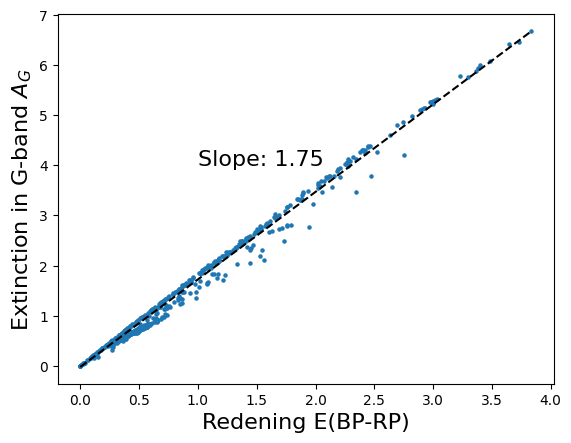

In [34]:
#display(xmm_crossmatched_orion[:1])
x=xmm_crossmatched_orion["E(BP-RP)"]
y=xmm_crossmatched_orion["AG"]
fit=np.polyfit(x,y,1)                            #Ag=a * E(Bp-Rp)

plt.scatter(x,y,s=5)
plt.annotate(f"Slope: {round(fit[0],2)}",[1,4],fontsize=16)
plt.xlabel("Redening E(BP-RP)",fontsize=16)
plt.ylabel(r"Extinction in G-band $A_G$",fontsize=16)
x=np.linspace(np.min(x),np.max(x),1000)
plt.plot(x,fit[0]*x+fit[1],c='black',linestyle='dashed')
#plt.plot(x,x*1.8)
print("a=",fit[0],"| b=",fit[1])
pente=fit[0]
decalage_y=0.97 #Car Ag = 0.97 * Av
decalage_x=0.97/fit[0]

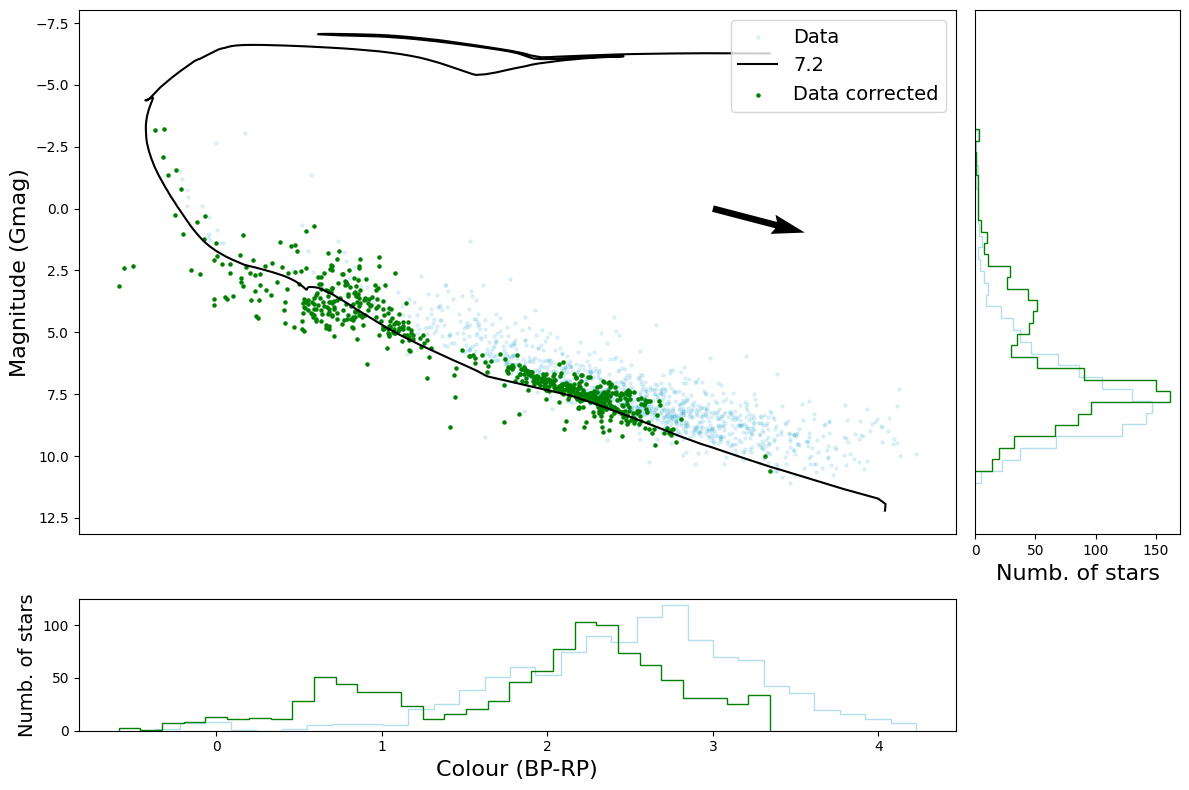

In [35]:
age=np.arange(6.5,7.5,0.1)
age=[round(x,2) for x in age]
isox,isoy=Iso(Av0,6.5,0.0152)

#pente=1.75 #Au cas ou la regression lineaire bloque
Gabs_crossmatched=xmm_crossmatched_orion["Gabs"]
Color_crossmatched=xmm_crossmatched_orion["BP-RP"]

Gabs_crossmatched_corrected=xmm_crossmatched_orion["Gabs_corrected"]
Color_crossmatched_corrected=xmm_crossmatched_orion["Color_corrected"]
####################################################################
fig=plt.figure(figsize=(12,8))
gs=fig.add_gridspec(4,5)

ax1=fig.add_subplot(gs[3,:4])


ax1.hist(Color_crossmatched,bins=30,edgecolor='#0096c7',color='#0096c7',histtype='step',alpha=0.3)

ax1.set_ylabel("Numb. of stars", fontsize=14)
ax1.set_xlabel("Colour (BP-RP)", fontsize=16)
####################################################################
ax2=fig.add_subplot(gs[0:3,:4])

'''
for A in age: #Plot des isochrone avec une absorption de 0.7 dans le visible
    x,y=Iso(Av0,A,0.0152)
    ax2.plot(x,y,zorder=2,label=A)
    meandist,midbins,sigma=MeanDist([x[(y>-2.5)],y[(y>-2.5)]],Color_crossmatched_corrected,Gabs_crossmatched_corrected,10)
    print(f"For age={A}, meandist={round((np.nanmean(meandist)),2)}, std= {round((np.nanmean((meandist-np.nanmean(meandist))**2)),2)}")
    print(f"Test: {np.nanmean(np.array(meandist)/np.array(sigma))}")
'''
x,y=Iso(Av0,7.2,0.0152)
ax2.scatter(Color_crossmatched,Gabs_crossmatched,s=5,color='#0096c7',zorder=0,label='Data',alpha=0.1)
ax2.plot(x,y,zorder=2,label=7.2,c='black')

ax2.set_ylabel("Magnitude (Gmag)", fontsize=16)
ax2.quiver(3,0,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1)
plt.gca().invert_yaxis()




#plt.xlabel("BP-RP")
plt.tick_params('x',which='both',bottom=False,top=False,labelbottom=False)
#c=xmm_crossmatched_orion["Teff"]
#ax.scatter_density(Color_crossmatched,Gabs_crossmatched,dpi=20,cmap='Blues')
####################################################################
ax3=fig.add_subplot(gs[0:3,4],sharey=ax2)

ax3.hist(Gabs_crossmatched,orientation='horizontal',bins=30,edgecolor='#0096c7'
         ,color='#0096c7',histtype='step',alpha=0.3)
#Le vert

ax1.hist(Color_crossmatched_corrected,bins=30,edgecolor='green',color='green',histtype='step')
ax2.scatter(Color_crossmatched_corrected,Gabs_crossmatched_corrected,s=5,color='green',zorder=1,label='Data corrected')
ax3.hist(Gabs_crossmatched_corrected,orientation='horizontal',bins=30,edgecolor='green',color='green',histtype='step')

ax2.legend(fontsize=14,loc='upper right')

ax3.set_xlabel("Numb. of stars",fontsize=16)
ax3.tick_params(labelleft=None,left=None)

plt.tight_layout()
#plt.savefig("Images/HR_Xmm_with_correction_and_final_isochrones.png")
#plt.savefig("Images/test.pdf")


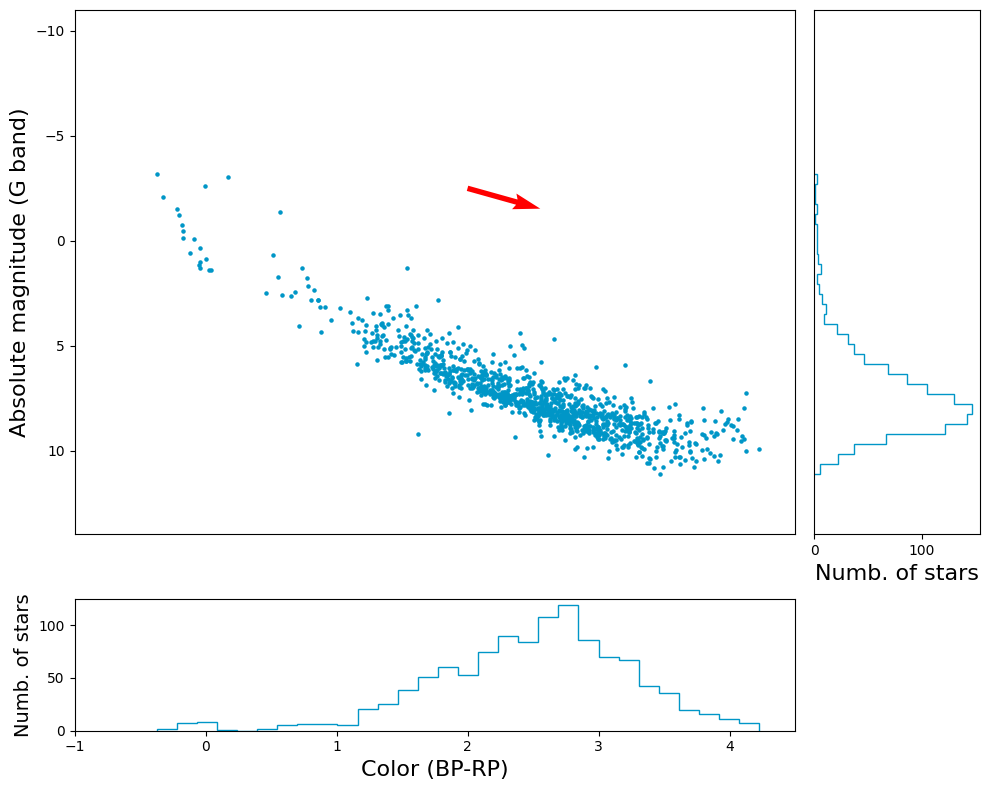

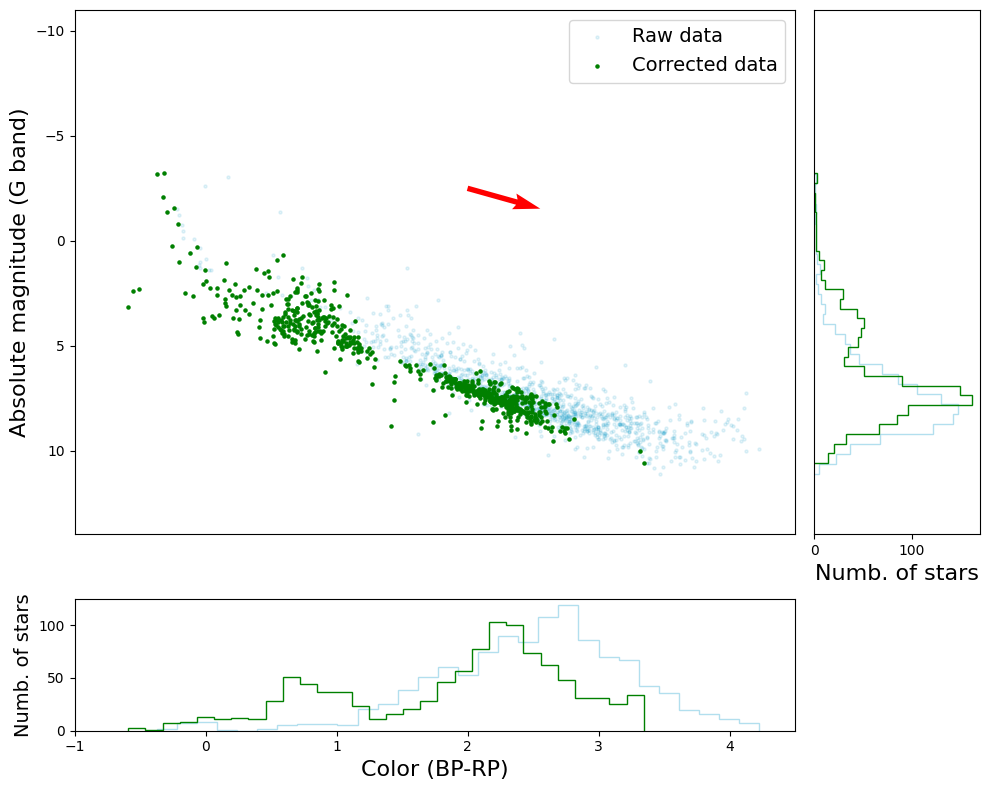

In [36]:
age=np.arange(6.5,8.1,0.5)
age=[round(x,2) for x in age]
x1 = xmm_crossmatched_orion["BP-RP"]
y1 = xmm_crossmatched_orion["Gabs"]
x2 = xmm_crossmatched_orion["Color_corrected"]
y2 = xmm_crossmatched_orion["Gabs_corrected"]
g=-1
d=4.5
h=14
b=-11

############################################ 1
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 5)

ax1 = fig.add_subplot(gs[0:3, :4])
ax1.scatter(x1, y1, s=5, color='#0096c7', zorder=0, label='Data')
ax1.quiver(2, -2.5, decalage_x, decalage_y, angles='xy', scale_units='xy', scale=1, color='red')
ax1.set_xlim(g, d)
ax1.set_ylim(h, b)
ax1.set_ylabel("Absolute magnitude (G band)", fontsize=16)
ax1.tick_params(labelbottom=None, bottom=None)

ax2 = fig.add_subplot(gs[3, :4], sharex=ax1)
ax2.hist(x1, bins=30, edgecolor='#0096c7', color='#0096c7', histtype='step')
ax2.set_ylabel("Numb. of stars", fontsize=14)
ax2.set_xlabel("Color (BP-RP)", fontsize=16)

ax3 = fig.add_subplot(gs[0:3, 4], sharey=ax1)
ax3.hist(y1, orientation='horizontal', bins=30, edgecolor='#0096c7', color='green', histtype='step')
ax3.set_xlabel("Numb. of stars", fontsize=16)
ax3.tick_params(labelleft=None, left=None)

plt.tight_layout()
plt.savefig("Images/1_HR_with_hist.pdf")


############################################ 2
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 5)

ax1 = fig.add_subplot(gs[0:3, :4])
ax1.scatter(x1, y1, s=5, color='#0096c7', zorder=0, label='Raw data'      ,alpha=0.1)
ax1.scatter(x2, y2, s=5, color='green'  , zorder=0, label='Corrected data')
ax1.quiver(2, -2.5, decalage_x, decalage_y, angles='xy', scale_units='xy', scale=1, color='red')
ax1.set_xlim(g, d)
ax1.set_ylim(h, b)
ax1.set_ylabel("Absolute magnitude (G band)", fontsize=16)
ax1.tick_params(labelbottom=None, bottom=None)
ax1.legend(fontsize=14)

ax2 = fig.add_subplot(gs[3, :4], sharex=ax1)
ax2.hist(x1, bins=30, edgecolor='#0096c7', color='#0096c7', histtype='step',alpha=0.3)
ax2.hist(x2, bins=30, edgecolor='green', color='green'  , histtype='step')
ax2.set_ylabel("Numb. of stars", fontsize=14)
ax2.set_xlabel("Color (BP-RP)", fontsize=16)

ax3 = fig.add_subplot(gs[0:3, 4], sharey=ax1)
ax3.hist(y1, orientation='horizontal', bins=30, edgecolor='#0096c7', color='green', histtype='step',alpha=0.3)
ax3.hist(y2, orientation='horizontal', bins=30, edgecolor='green'  , color='green', histtype='step')
ax3.set_xlabel("Numb. of stars", fontsize=16)
ax3.tick_params(labelleft=None, left=None)

plt.tight_layout()
plt.savefig("Images/2_HR_with_hist.pdf")


# ############################################ 3
# fig = plt.figure(figsize=(10, 8))
# gs = fig.add_gridspec(4, 5)

# ax1 = fig.add_subplot(gs[0:3, :4])
# ax1.scatter(x1, y1, s=5, color='#0096c7', zorder=0,alpha=0.1)
# ax1.scatter(x2, y2, s=5, color='green'  , zorder=0)
# for A in age:
#     x,y=Iso(Av0,A,0.0152)
#     plt.plot(x,y,zorder=2,label=A)
# ax1.quiver(2, -2.5, decalage_x, decalage_y, angles='xy', scale_units='xy', scale=1, color='red')
# ax1.set_xlim(g, d)
# ax1.set_ylim(h, b)
# ax1.legend(fontsize=14,loc='lower left')
# ax1.set_ylabel("Absolute magnitude (G band)", fontsize=16)
# ax1.tick_params(labelbottom=None, bottom=None)

# ax2 = fig.add_subplot(gs[3, :4], sharex=ax1)
# ax2.hist(x1, bins=30, edgecolor='#0096c7', color='#0096c7', histtype='step',alpha=0.3)
# ax2.hist(x2, bins=30, edgecolor='green', color='green'  , histtype='step')
# ax2.set_ylabel("Numb. of stars", fontsize=14)
# ax2.set_xlabel("Color (BP-RP)", fontsize=16)

# ax3 = fig.add_subplot(gs[0:3, 4], sharey=ax1)
# ax3.hist(y1, orientation='horizontal', bins=30, edgecolor='#0096c7', color='green', histtype='step',alpha=0.3)
# ax3.hist(y2, orientation='horizontal', bins=30, edgecolor='green'  , color='green', histtype='step')
# ax3.set_xlabel("Numb. of stars", fontsize=16)
# ax3.tick_params(labelleft=None, left=None)

# plt.tight_layout()
# plt.savefig("Images/3_HR_with_hist.pdf")



# ############################################ 4
# fig = plt.figure(figsize=(10, 8))
# gs = fig.add_gridspec(4, 5)

# ax1 = fig.add_subplot(gs[0:3, :4])
# ax1.scatter(x1, y1, s=5, color='#0096c7', zorder=0, label='Raw data'      ,alpha=0.1)
# ax1.scatter(x2, y2, s=5, color='green'  , zorder=0, label='Corrected data')
# plt.plot(*Iso(Av0,7.2,0.0152),zorder=2,label=7.2,c='black')
# ax1.quiver(2, -2.5, decalage_x, decalage_y, angles='xy', scale_units='xy', scale=1, color='red')
# ax1.set_xlim(g, d)
# ax1.set_ylim(h, b)
# ax1.legend(fontsize=14)
# ax1.set_ylabel("Absolute magnitude (G band)", fontsize=16)
# ax1.tick_params(labelbottom=None, bottom=None)

# ax2 = fig.add_subplot(gs[3, :4], sharex=ax1)
# ax2.hist(x1, bins=30, edgecolor='#0096c7', color='#0096c7', histtype='step',alpha=0.3)
# ax2.hist(x2, bins=30, edgecolor='green', color='green'  , histtype='step')
# ax2.set_ylabel("Numb. of stars", fontsize=14)
# ax2.set_xlabel("Color (BP-RP)", fontsize=16)

# ax3 = fig.add_subplot(gs[0:3, 4], sharey=ax1)
# ax3.hist(y1, orientation='horizontal', bins=30, edgecolor='#0096c7', color='green', histtype='step',alpha=0.3)
# ax3.hist(y2, orientation='horizontal', bins=30, edgecolor='green'  , color='green', histtype='step')
# ax3.set_xlabel("Numb. of stars", fontsize=16)
# ax3.tick_params(labelleft=None, left=None)

# plt.tight_layout()
# plt.savefig("Images/4_HR_with_hist.pdf")

In [37]:
#With error bars

# x1=xmm_crossmatched_orion["BP-RP"]
# y1=xmm_crossmatched_orion["Gabs"]

# x1err=np.sqrt(xmm_crossmatched_orion["e_RPmag"]**2 + xmm_crossmatched_orion["e_BPmag"]**2)
# y1err=xmm_crossmatched_orion["e_Gabs"]


# plt.figure(figsize=(12,8))

# plt.scatter(x1,y1,s=10)
# plt.errorbar(x1,y1,y1err,x1err,fmt="_")

# plt.gca().invert_yaxis()

# plt.figure(figsize=(12,3))


# plt.scatter(xmm_crossmatched_orion["BP-RP"],y1err,s=1)
# print(np.max(x1err))

In [38]:
# # Error propagation distrib

# subset=x1err/xmm_crossmatched_orion["BP-RP"]

# _=plt.hist(subset,bins=80,range=[0,0.1],edgecolor='black')

# print(np.median(x1err))
# plt.show()
# plt.close()

# subset=y1err/xmm_crossmatched_orion["Gabs"]

# _=plt.hist(subset,bins=80,range=[0,0.1],edgecolor='black')

# print(np.median(y1err))

## plot du couleur-magnitude

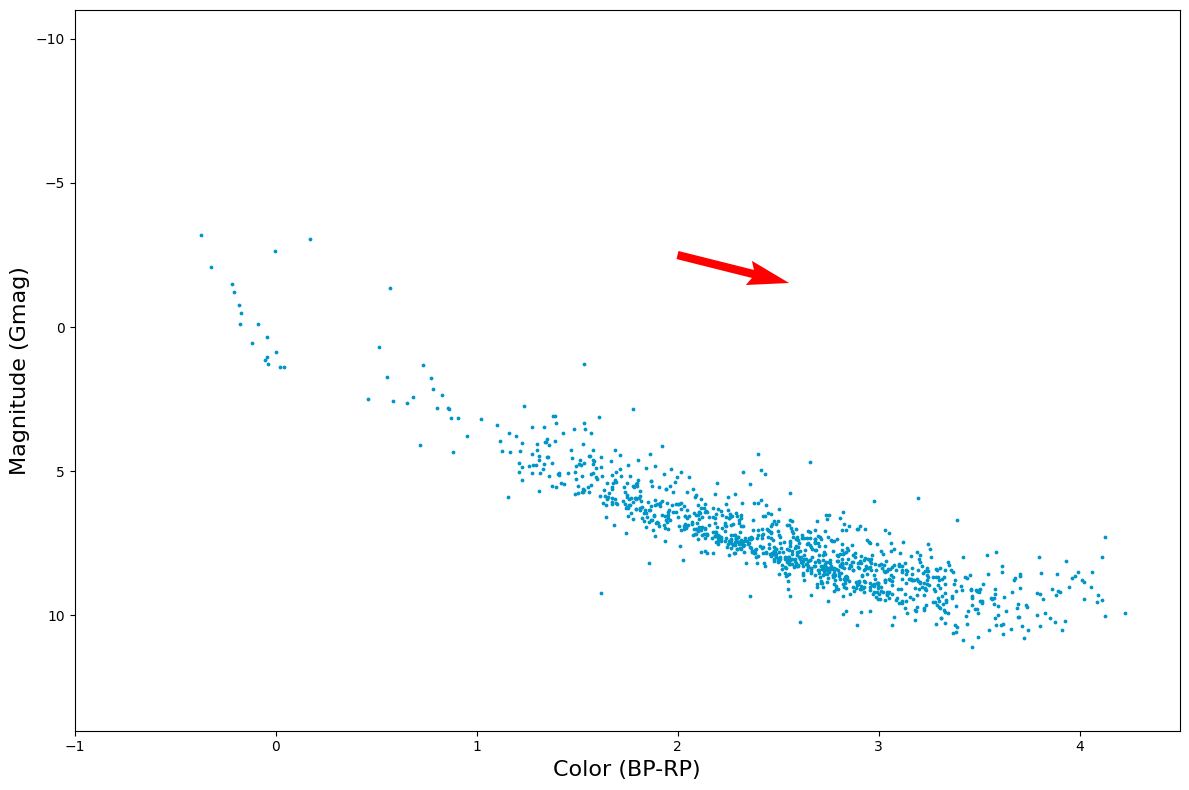

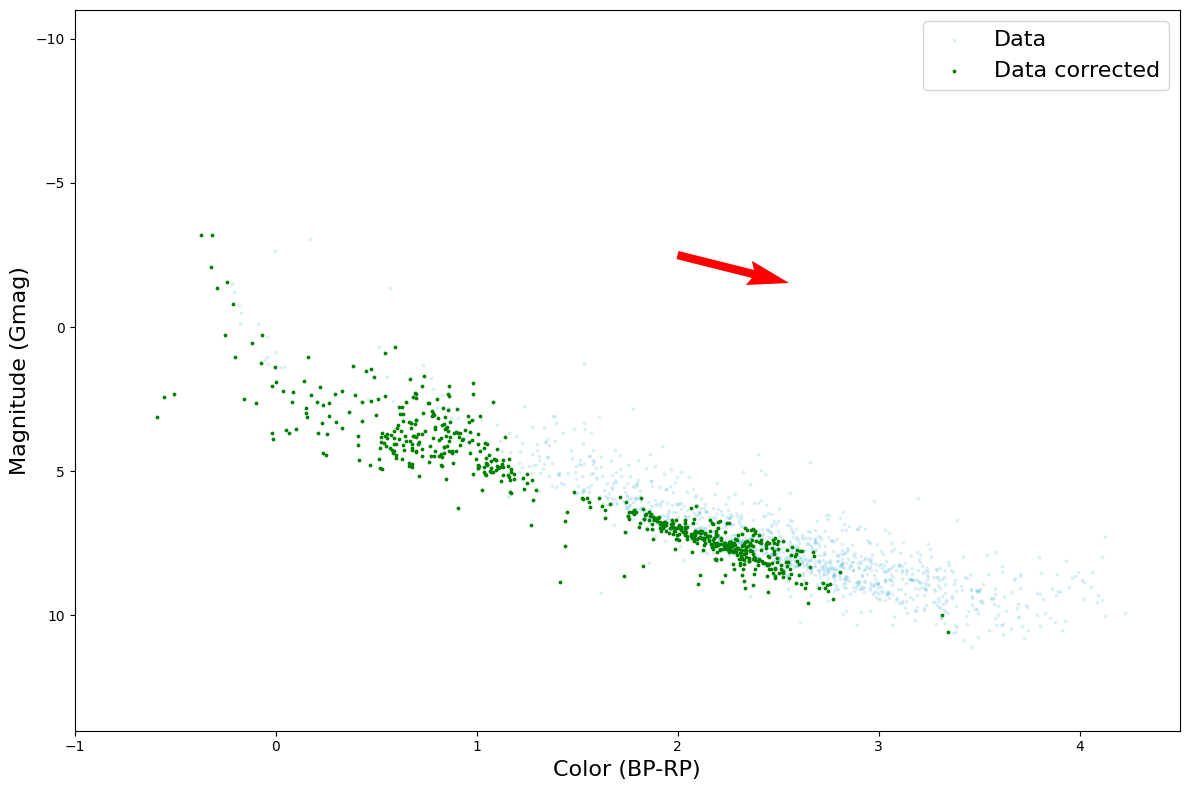

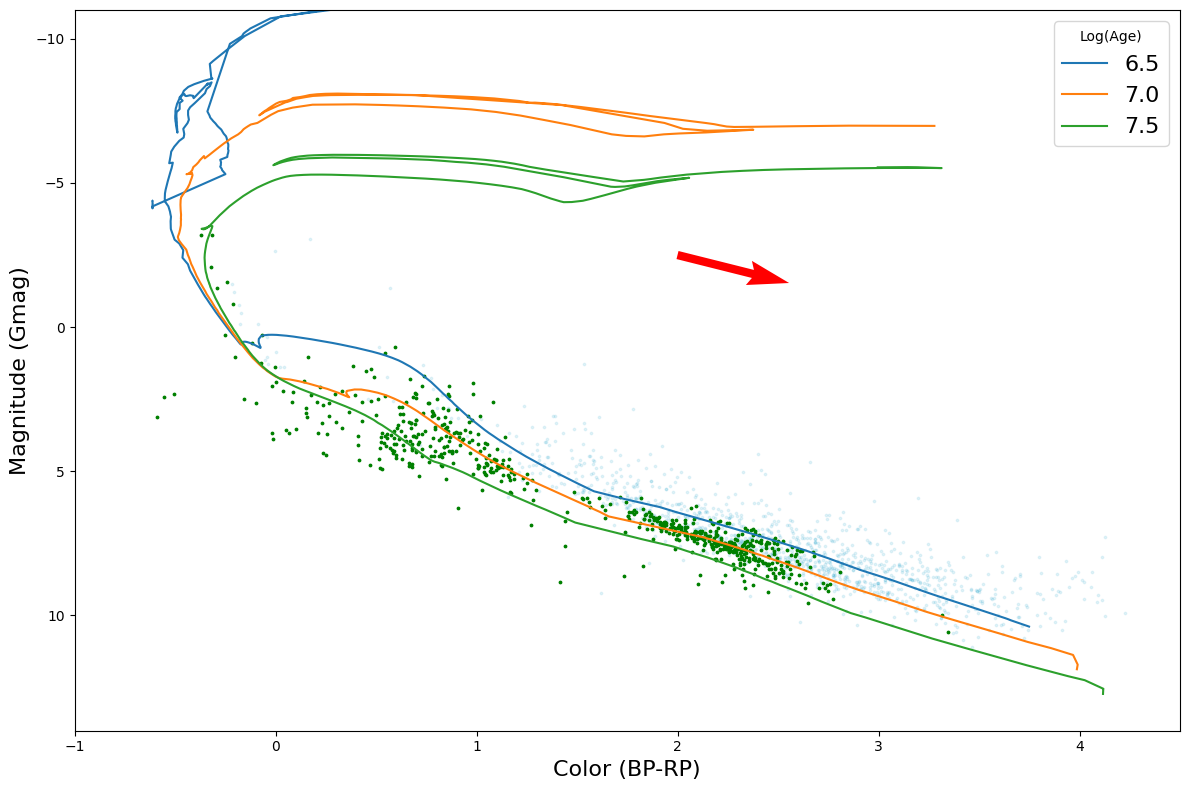

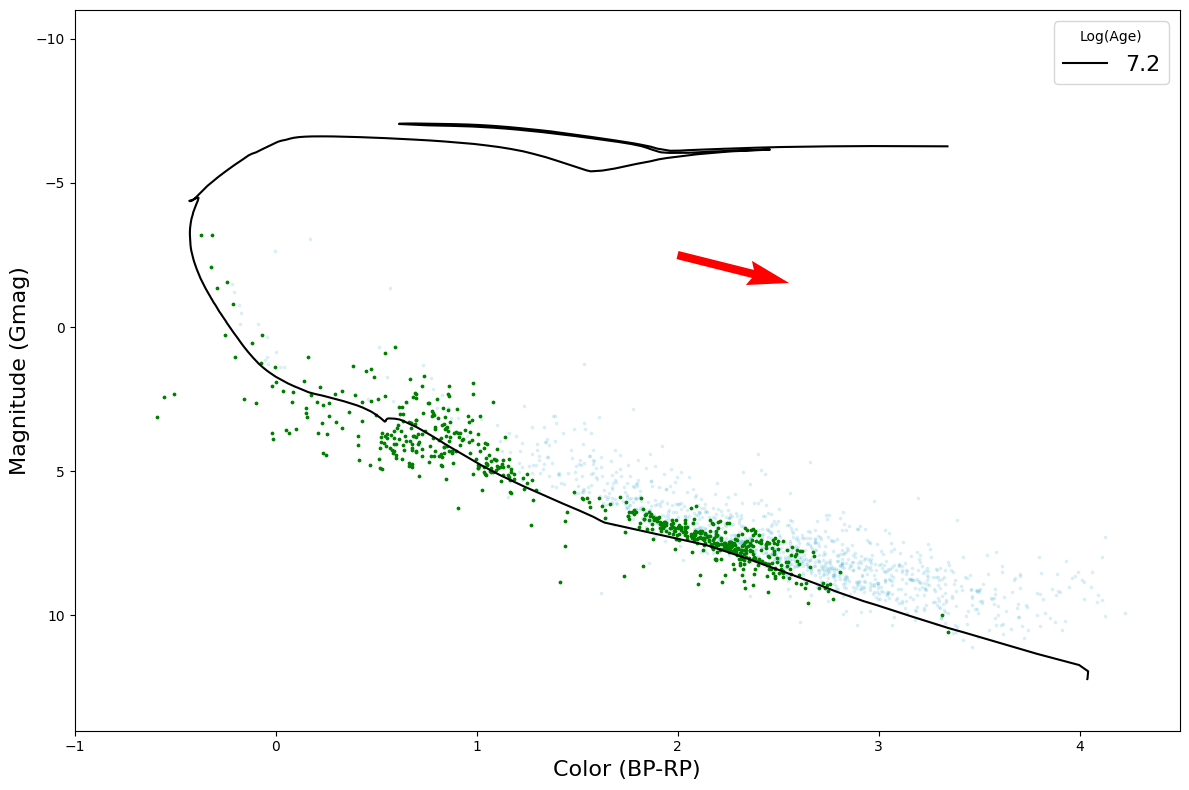

In [39]:
x1=xmm_crossmatched_orion["BP-RP"]
y1=xmm_crossmatched_orion["Gabs"]

x2=xmm_crossmatched_orion["Color_corrected"]
y2=xmm_crossmatched_orion["Gabs_corrected"]

g=-1
d=4.5
h=14
b=-11

age=np.arange(6.5,7.6,0.5)
age=[round(x,2) for x in age]



############################################ 1
plt.figure(figsize=(12,8))

plt.scatter(x1,y1,c="#0096c7",s=3)
plt.quiver(2,-2.5 ,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1 , color='red')

plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Magnitude (Gmag)", fontsize=16)
plt.xlim(g,d)
plt.ylim(b,h)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Images/1_HR.pdf")


############################################ 2HR=
plt.figure(figsize=(12,8))

plt.scatter(x1,y1,c="#0096c7",alpha=0.1,s=3,label="Data")
plt.scatter(x2,y2,c="green",s=3,label="Data corrected")
plt.quiver(2,-2.5 ,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1 , color='red')

plt.legend(fontsize=16)
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Magnitude (Gmag)", fontsize=16)
plt.xlim(g,d)
plt.ylim(b,h)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Images/2_HR.pdf")


############################################ 3
plt.figure(figsize=(12,8))

for A in age:
    x,y=Iso(Av0,A,0.0152)
    plt.plot(x,y,zorder=2,label=A)
plt.scatter(x1,y1,c="#0096c7",alpha=0.1,s=3)
plt.scatter(x2,y2,c="green",s=3)
plt.quiver(2,-2.5 ,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1 , color='red')

plt.legend(fontsize=16,title="Log(Age)")
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Magnitude (Gmag)", fontsize=16)
plt.xlim(g,d)
plt.ylim(b,h)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Images/3_HR.pdf")

############################################ 4
plt.figure(figsize=(12,8))

X,Y=Iso(Av0,7.2,0.0152)

plt.plot(X,Y,zorder=2,label=7.2,c='black')
plt.scatter(x1,y1,c="#0096c7",alpha=0.1,s=3)
plt.scatter(x2,y2,c="green",s=3)
plt.quiver(2,-2.5 ,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1 , color='red')

plt.legend(fontsize=16,title="Log(Age)")
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Magnitude (Gmag)", fontsize=16)
plt.xlim(g,d)
plt.ylim(b,h)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Images/4_HR.pdf")

# plt.figure(figsize=(12,8))

# X,Y=Iso(Av1,7,0.0152)

# for A in age:
#     x,y=Iso(Av1,A,0.0152)
#     plt.plot(x,y,zorder=2,label=A)
    
# plt.scatter(x1,y1,c="#0096c7",s=3)
# plt.quiver(2,-2.5 ,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1 , color='red')

# plt.legend(fontsize=16,title="Log(Age)")
# plt.xlabel("Color (BP-RP)", fontsize=16)
# plt.ylabel("Magnitude (Gmag)", fontsize=16)
# plt.xlim(g,d)
# plt.ylim(b,h)
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig("Images/.png")


In [40]:
# #Masse en couleur

# TABLE=readfile(Av0)
# mask_age=(TABLE["logAge"]==7)
# mask_metal=(TABLE["Zini"]==0.0152)
# mastermask=mask_age & mask_metal
# x,y=XY(TABLE,parsec1_2s_gaia_dr2)
# x=x[mastermask]
# y=y[mastermask]
# M=TABLE["Mini"][mastermask]
# plt.scatter(x,y,c=M,cmap='Spectral',norm=LogNorm())
# plt.colorbar()
# plt.gca().invert_yaxis()

## Overplot des isochrones

In [41]:
parsec2_gaia_dr2=["G_fSBmag","G_BP_fSBmag","G_RP_fSBmag"]
parsec1_2s_gaia_dr2=["Gmag","G_BPmag","G_RPmag"]

## Plot des points corrige

In [42]:
# Ag=gaia_cleanuped["AG"]
# E=gaia_cleanuped["E(BP-RP)"]

# Ag_crossmatched=xmm_crossmatched_orion["AG"]
# E_crossmatched=xmm_crossmatched_orion["E(BP-RP)"]

# file1="/home/thomas/Documents/0_Stage/Code/Isochrones/parsec1_2_Av_0_Age_7_metal_1_5.dat"
# x1,y1=Iso(file1,7,0.0152)
# x2,y2=Iso(file2,7,0.0152)

# Color_gaia_corrected=Color_gaia-E
# Gabs_gaia_corrected=Gabs_gaia-Ag
# Color_crossmatched_corrected=Color_crossmatched-E_crossmatched
# Gabs_crossmatched_corrected=Gabs_crossmatched-Ag_crossmatched


# fig=plt.figure(figsize=(8,8))
# gs = plt.GridSpec(7, 1)

# ax1=plt.subplot(gs[:3,0])
# ax1.plot(x1,y1,zorder=1,label="Av=0")
# ax1.plot(x2,y2,zorder=1,label="Av=1")

# ax1.scatter(Color_gaia,Gabs_gaia,s=1,zorder=0,c='orange',cmap="inferno")
# ax1.scatter(Color_gaia_corrected,Gabs_gaia_corrected,s=1,zorder=0,c='green',cmap="inferno")
# '''
# ax1.scatter(Color_crossmatched,Gabs_crossmatched,s=1,zorder=0,c='brown',cmap="inferno")
# ax1.scatter(Color_crossmatched_corrected,Gabs_crossmatched_corrected,s=1,zorder=0,c='red',cmap="inferno")
# '''

# ax1.set_ylabel("Gabs")
# ax1.quiver(3,0,      decalage_x,decalage_y      ,angles='xy', scale_units='xy', scale=1)
# plt.gca().invert_yaxis()
# plt.legend()

# ax2=plt.subplot(gs[3,0],sharex=ax1)
# temp=ax2.hist(Color_gaia,bins=50,color='orange',edgecolor='black')
# ax2.set_ylabel("Gaia")

# ax3=plt.subplot(gs[4,0],sharex=ax1,sharey=ax2)
# temp=ax3.hist(Color_gaia_corrected,bins=50,color='green',edgecolor='black')
# ax3.set_ylabel("Gaia_corrected")


# ax4=plt.subplot(gs[5,0],sharex=ax1,sharey=ax2)
# temp=ax4.hist(Color_crossmatched,bins=50,color='brown',edgecolor='black')
# ax4.set_ylabel("Cross")

# ax5=plt.subplot(gs[6,0],sharex=ax1,sharey=ax2)
# temp=ax5.hist(Color_crossmatched_corrected,bins=50,color='red',edgecolor='black')
# ax5.set_ylabel("Cross_corrected")
# ax5.set_xlabel("Bp-Rp")

# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax2.get_xticklabels(), visible=False)
# plt.setp(ax3.get_xticklabels(), visible=False)
# plt.setp(ax4.get_xticklabels(), visible=False)

### Test de Diagram Couleur vs Temperature

(40000, 2500)

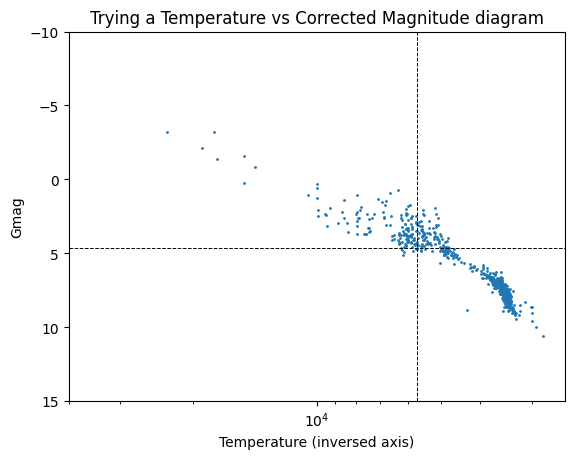

In [43]:
Ag=xmm_crossmatched_orion["AG"]
Dist=1/xmm_crossmatched_orion["Plx"] *1000
Gabs_sun=4.67                            #Valeur de Gabs_sun a verif (http://mips.as.arizona.edu/~cnaw/sun.html)
Grelat=xmm_crossmatched_orion["Gmag"]
Gabs=(Grelat-5*np.log10(Dist)+5)-Ag
plt.scatter(xmm_crossmatched_orion["Teff"],Gabs,s=1)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("Temperature (inversed axis)")
plt.ylabel("Gmag")
plt.title("Trying a Temperature vs Corrected Magnitude diagram")
plt.axvline(5700,c='black',linestyle='dashed',linewidth=0.7)
plt.axhline(Gabs_sun,c='black',linestyle='dashed',linewidth=0.7)
plt.ylim(15,-10)
plt.xlim(40000,2500)

## Calcul du Nh moyen

We assume that all stars have an extinction of Ag= 0.68
Since Av=Ag/0.97, we get Av= 0.7
And since E(B-R)=Ag/1.74, we get E(B-R)= 0.39
At the end, Nh= 1.266995901913987e+21
Jsp si on prend la median, dans ce cas: median_Av= 0.8397938049945635  Et donc Nh= 1.5116288489902142e+21


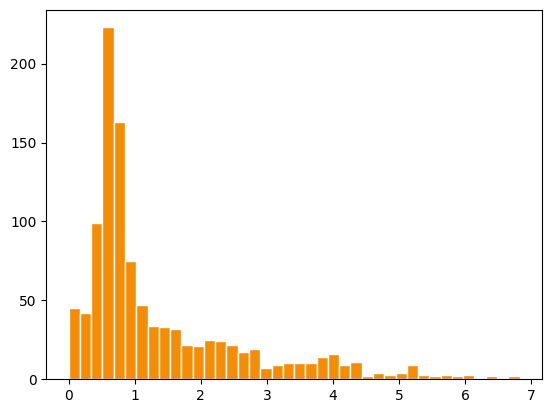

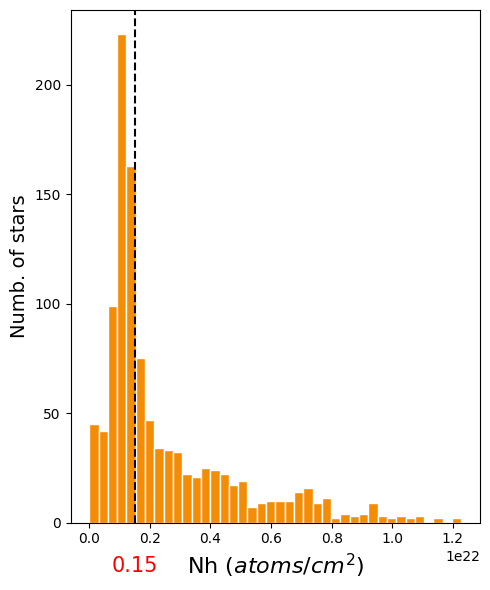

In [49]:
# plt.figure(figsize=(5,6))

subset=list(gaia_cleanuped["AG"][gaia_cleanuped["AG"]>=0])

temp=plt.hist(subset,bins=40,color='#f48c06',edgecolor='white')

heigh=list(temp[0])
i=heigh.index(np.max(heigh))
Ag_avg=temp[1][i+1]
Av_avg=Ag_avg/0.97
E_avg=Ag_avg/pente


Nh=1.8*1e21*Av_avg


# plt.axvline(Ag_avg,c='black',linestyle='dashed')
# plt.text(Ag_avg,-5,round(Ag_avg,2),color='red',fontsize=11,va='center',ha='center')
#plt.axvline(np.median(subset),c='red',linestyle='dashed') #On prend la mediane??????
print("We assume that all stars have an extinction of Ag=",round(Ag_avg,2))
print("Since Av=Ag/0.97, we get Av=",round(Ag_avg/0.97,2))
print("And since E(B-R)=Ag/1.74, we get E(B-R)=",round(E_avg,2))
print("At the end, Nh=",Nh)
print("Jsp si on prend la median, dans ce cas: median_Av=",np.median(subset)/0.97," Et donc Nh=",1.8*1e21*(np.median(subset)/0.97))

# plt.xlabel("Ag distribution",fontsize=14)
# plt.ylabel("Numb. of stars",fontsize=14)
# plt.tight_layout()
# plt.savefig("Images/Ag_distrib.png")

plt.figure(figsize=(5,6))

subset = np.array((gaia_cleanuped["AG"][gaia_cleanuped["AG"]>=0])) * 1.8 * 10**(21)

temp=plt.hist(subset,bins=40,color='#f48c06',edgecolor='white')

plt.xlabel(r"Nh ($atoms/cm^2$)",fontsize=16)
plt.ylabel("Numb. of stars",fontsize=14)

plt.axvline(1.5116e21,c='black',linestyle='dashed') #Flemme
plt.text(0.15e22,-20,0.15,color='red',fontsize=15,va='center',ha='center') #Flemme
plt.tight_layout()

plt.savefig("Images/Nh_distrib.png")


In [ ]:
x=xmm_crossmatched_orion["BP-RP"]
y=xmm_crossmatched_orion["AG"]
X=xmm_crossmatched_orion["Color_corrected"]

plt.scatter(x,y,s=5,c="#0096c7")
plt.scatter(X,y,s=5,c='orange')

#plt.gca().invert_yaxis()
plt.xlabel("Color (BP-RP)",fontsize=14)
plt.ylabel("Extinction (Ag)",fontsize=14)
plt.tight_layout()

## Calcul des moyennes de distances entre les points et l'isochrone

In [ ]:
# X,Y=Iso(file1,7,0.0152)

# ax1=plt.subplot(2,1,1)
# x=gaia_cleanuped["BP-RP"]-E_avg
# y=gaia_cleanuped["Gmag"]-5*np.log10(1/gaia_cleanuped["Plx"] *1000)+5-Ag_avg
# ax1.scatter(x,y,s=1,c='orange')
# ax1.plot(X,Y,c='blue')
# ax1.set_ylabel("Gabs")
# plt.gca().invert_yaxis()

# ax2=plt.subplot(2,1,2,sharex=ax1)
# meandist,midbins=MeanDist([X,Y],x,y,30)
# ax2.scatter(midbins,meandist,s=15,c='orange',label="")
# ax2.axhline(0,c='black',linestyle='dashed',linewidth='0.6')
# plt.gca().invert_yaxis()

# x=gaia_cleanuped["BP-RP"]
# y=gaia_cleanuped["Gmag"]-5*np.log10(1/gaia_cleanuped["Plx"] *1000)+5
# ax1.scatter(x,y,s=1,c='red')

# meandist,midbins=MeanDist([X,Y],x,y,30)
# ax2.scatter(midbins,meandist,s=15,c='red',label="")
# ax2.axhline(0,c='black',linestyle='dashed',linewidth='0.6')



In [ ]:
print(Av_avg)

In [ ]:
# xmm_crossmatched_orion = Table.read('/home/thomas/Documents/0_Stage/Code/Tables/finished_table.fits')

# Raw catalog manipulation

In [50]:
ECF_Soft=4.7*1e11
ECF_Hard=1.25*1e11
ECF_All=4.32*1e11 #Au cas ou

In [51]:
all_xmm_raw=Table.read('./Tables/all_xmm_raw.fits')

In [52]:
print(len(all_xmm_raw))

895415


In [53]:
merging=table.join(xmm_crossmatched_orion,all_xmm_raw,keys_left="Source_1",keys_right="SRCID",join_type='inner')
merging=merging.group_by("SRCID") #Utile pour l'aggregate
orion_raw=Table()
for col in all_xmm_raw.colnames:
    orion_raw[col]=merging[col]
orion_raw.add_column(orion_raw["PN_1_RATE"]+orion_raw["PN_2_RATE"]+orion_raw["PN_3_RATE"],name="PN_6_RATE")
orion_raw.add_column(orion_raw["PN_4_RATE"]+orion_raw["PN_5_RATE"],name="PN_7_RATE")
orion_raw=orion_raw.group_by("SRCID") #Pour la ligne d'apres
print("We aggregate..")
orion_mean=orion_raw.groups.aggregate(np.mean) #Fusionne les lignes avec le meme SRCID (grace au group by) et fait la moyenne
print("Done")

We aggregate..
Done


In [54]:
# orion_mean.write('./Tables/orion_mean.fits',format='fits',overwrite=True)
# orion_mean=Table.read('./Tables/orion_mean.fits',format='fits')

In [55]:
#Cellule de check
print("Taille du catalog crossmatched",len(xmm_crossmatched_orion))
print("Taille du nouveau catalog moyene",len(orion_mean))

Taille du catalog crossmatched 1122
Taille du nouveau catalog moyene 1122


### Cellule de remplacement Flux_8 test

In [56]:
#orion_mean.replace_column("Flux_8",orion_mean["PN_8_RATE"]/(ECF_All))
display(orion_mean[:1])

DETID,SRCID,DR3SRCID,DR3DETID,DR3DETDIST,DR3SRCDIST,DR3MULT,DR4SRCID,DR4DETID,DR4DETDIST,DR4SRCDIST,DR4MULT,SRC_NUM,MJD_START,MJD_STOP,OBS_CLASS,RA,DEC,POSERR,LII,BII,RADEC_ERR,SYSERRCC,REFCAT,POSCOROK,RA_UNC,DEC_UNC,CCDPN,PN_RAWX,PN_RAWY,CCDM1,M1_RAWX,M1_RAWY,CCDM2,M2_RAWX,M2_RAWY,EP_1_FLUX,EP_1_FLUX_ERR,EP_2_FLUX,EP_2_FLUX_ERR,EP_3_FLUX,EP_3_FLUX_ERR,EP_4_FLUX,EP_4_FLUX_ERR,EP_5_FLUX,EP_5_FLUX_ERR,EP_8_FLUX,EP_8_FLUX_ERR,EP_9_FLUX,EP_9_FLUX_ERR,PN_1_FLUX,PN_1_FLUX_ERR,PN_2_FLUX,PN_2_FLUX_ERR,PN_3_FLUX,PN_3_FLUX_ERR,PN_4_FLUX,PN_4_FLUX_ERR,PN_5_FLUX,PN_5_FLUX_ERR,PN_8_FLUX,PN_8_FLUX_ERR,PN_9_FLUX,PN_9_FLUX_ERR,M1_1_FLUX,M1_1_FLUX_ERR,M1_2_FLUX,M1_2_FLUX_ERR,M1_3_FLUX,M1_3_FLUX_ERR,M1_4_FLUX,M1_4_FLUX_ERR,M1_5_FLUX,M1_5_FLUX_ERR,M1_8_FLUX,M1_8_FLUX_ERR,M1_9_FLUX,M1_9_FLUX_ERR,M2_1_FLUX,M2_1_FLUX_ERR,M2_2_FLUX,M2_2_FLUX_ERR,M2_3_FLUX,M2_3_FLUX_ERR,M2_4_FLUX,M2_4_FLUX_ERR,M2_5_FLUX,M2_5_FLUX_ERR,M2_8_FLUX,M2_8_FLUX_ERR,M2_9_FLUX,M2_9_FLUX_ERR,EP_8_RATE,EP_8_RATE_ERR,EP_9_RATE,EP_9_RATE_ERR,PN_1_RATE,PN_1_RATE_ERR,PN_2_RATE,PN_2_RATE_ERR,PN_3_RATE,PN_3_RATE_ERR,PN_4_RATE,PN_4_RATE_ERR,PN_5_RATE,PN_5_RATE_ERR,PN_8_RATE,PN_8_RATE_ERR,PN_9_RATE,PN_9_RATE_ERR,M1_1_RATE,M1_1_RATE_ERR,M1_2_RATE,M1_2_RATE_ERR,M1_3_RATE,M1_3_RATE_ERR,M1_4_RATE,M1_4_RATE_ERR,M1_5_RATE,M1_5_RATE_ERR,M1_8_RATE,M1_8_RATE_ERR,M1_9_RATE,M1_9_RATE_ERR,M2_1_RATE,M2_1_RATE_ERR,M2_2_RATE,M2_2_RATE_ERR,M2_3_RATE,M2_3_RATE_ERR,M2_4_RATE,M2_4_RATE_ERR,M2_5_RATE,M2_5_RATE_ERR,M2_8_RATE,M2_8_RATE_ERR,M2_9_RATE,M2_9_RATE_ERR,EP_8_CTS,EP_8_CTS_ERR,PN_8_CTS,PN_8_CTS_ERR,M1_8_CTS,M1_8_CTS_ERR,M2_8_CTS,M2_8_CTS_ERR,EP_8_DET_ML,EP_9_DET_ML,PN_1_DET_ML,PN_2_DET_ML,PN_3_DET_ML,PN_4_DET_ML,PN_5_DET_ML,PN_8_DET_ML,PN_9_DET_ML,M1_1_DET_ML,M1_2_DET_ML,M1_3_DET_ML,M1_4_DET_ML,M1_5_DET_ML,M1_8_DET_ML,M1_9_DET_ML,M2_1_DET_ML,M2_2_DET_ML,M2_3_DET_ML,M2_4_DET_ML,M2_5_DET_ML,M2_8_DET_ML,M2_9_DET_ML,EP_EXTENT,EP_EXTENT_ERR,EP_EXTENT_ML,EP_HR1,EP_HR1_ERR,EP_HR2,EP_HR2_ERR,EP_HR3,EP_HR3_ERR,EP_HR4,EP_HR4_ERR,PN_HR1,PN_HR1_ERR,PN_HR2,PN_HR2_ERR,PN_HR3,PN_HR3_ERR,PN_HR4,PN_HR4_ERR,M1_HR1,M1_HR1_ERR,M1_HR2,M1_HR2_ERR,M1_HR3,M1_HR3_ERR,M1_HR4,M1_HR4_ERR,M2_HR1,M2_HR1_ERR,M2_HR2,M2_HR2_ERR,M2_HR3,M2_HR3_ERR,M2_HR4,M2_HR4_ERR,PN_1_EXP,PN_2_EXP,PN_3_EXP,PN_4_EXP,PN_5_EXP,M1_1_EXP,M1_2_EXP,M1_3_EXP,M1_4_EXP,M1_5_EXP,M2_1_EXP,M2_2_EXP,M2_3_EXP,M2_4_EXP,M2_5_EXP,PN_1_BG,PN_2_BG,PN_3_BG,PN_4_BG,PN_5_BG,M1_1_BG,M1_2_BG,M1_3_BG,M1_4_BG,M1_5_BG,M2_1_BG,M2_2_BG,M2_3_BG,M2_4_BG,M2_5_BG,PN_PILEUP,M1_PILEUP,M2_PILEUP,PN_1_VIG,PN_2_VIG,PN_3_VIG,PN_4_VIG,PN_5_VIG,M1_1_VIG,M1_2_VIG,M1_3_VIG,M1_4_VIG,M1_5_VIG,M2_1_VIG,M2_2_VIG,M2_3_VIG,M2_4_VIG,M2_5_VIG,PN_ONTIME,M1_ONTIME,M2_ONTIME,EP_ONTIME,PN_OFFAX,M1_OFFAX,M2_OFFAX,EP_OFFAX,PN_MASKFRAC,M1_MASKFRAC,M2_MASKFRAC,DIST_NN,SUM_FLAG,TSERIES,SPECTRA,EP_CHI2PROB,PN_CHI2PROB,M1_CHI2PROB,M2_CHI2PROB,PN_FVAR,PN_FVARERR,M1_FVAR,M1_FVARERR,M2_FVAR,M2_FVARERR,VAR_FLAG,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,HIGH_BACKGROUND,PN_6_RATE,PN_7_RATE
,,,,arcsec,arcsec,,,,arcsec,arcsec,,,d,d,,deg,deg,arcsec,deg,deg,arcsec,arcsec,,,deg,deg,,,,,,,,,,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s)

## 1 ECF

In [57]:
'''
liste_flux=[1,2,3,4,5,8]
try: #Pour pas avoir d'erreur
    for i in liste_flux:
        orion_mean.add_column(orion_mean[f"PN_{i}_RATE"]/(ECF_Soft) , name=f"Flux_{i}")
    orion_mean.add_column(orion_mean["Flux_1"]+orion_mean["Flux_2"]+orion_mean["Flux_3"] , name="Flux_6")
    orion_mean.add_column(orion_mean["Flux_4"]+orion_mean["Flux_5"] , name="Flux_7")
    orion_mean.add_column(orion_mean["Flux_6"]+orion_mean["Flux_7"] , name="Flux_8")
    orion_mean.add_column(np.sqrt((orion_mean["PN_1_RATE_ERR"])**2 + (orion_mean["PN_2_RATE_ERR"])**2 + (orion_mean["PN_3_RATE_ERR"])**2 + (orion_mean["PN_4_RATE_ERR"])**2 + (orion_mean["PN_5_RATE_ERR"])**2)/ECF_All , name="Flux_8_err")
    display(orion_mean[:1])
    n_ecf=1
except:
    for i in liste_flux:
        orion_mean.replace_column(f"Flux_{i}",orion_mean[f"PN_{i}_RATE"]/(ECF_Soft))
    orion_mean.replace_column("Flux_6",orion_mean["Flux_1"]+orion_mean["Flux_2"]+orion_mean["Flux_3"])
    orion_mean.replace_column("Flux_7",orion_mean["Flux_4"]+orion_mean["Flux_5"])
    orion_mean.replace_column("Flux_8",orion_mean["Flux_6"]+orion_mean["Flux_7"])
    orion_mean.replace_column("Flux_8_err",np.sqrt((orion_mean["PN_1_RATE_ERR"])**2 + (orion_mean["PN_2_RATE_ERR"])**2 + (orion_mean["PN_3_RATE_ERR"])**2 + (orion_mean["PN_4_RATE_ERR"])**2 + (orion_mean["PN_5_RATE_ERR"])**2)/ECF_All)
    display(orion_mean[:1])
    n_ecf=1
'''
print("")

## 2 ECF

In [58]:
Soft=[1,2,3]
Hard=[4,5]
try:
    for i in Soft:
        orion_mean.add_column(orion_mean[f"PN_{i}_RATE"]/(ECF_Soft) , name=f"Flux_{i}")
    for i in Hard:
        orion_mean.add_column(orion_mean[f"PN_{i}_RATE"]/(ECF_Hard) , name=f"Flux_{i}")
    orion_mean.add_column(orion_mean["Flux_1"]+orion_mean["Flux_2"]+orion_mean["Flux_3"] , name="Flux_6")
    orion_mean.add_column(orion_mean["Flux_4"]+orion_mean["Flux_5"] , name="Flux_7")
    orion_mean.add_column(orion_mean["Flux_6"]+orion_mean["Flux_7"] , name="Flux_8")
    orion_mean.add_column(np.sqrt(((orion_mean["PN_1_RATE_ERR"])**2 + (orion_mean["PN_2_RATE_ERR"])**2 + (orion_mean["PN_3_RATE_ERR"])**2)/(ECF_Soft**2) + ((orion_mean["PN_4_RATE_ERR"])**2 + (orion_mean["PN_5_RATE_ERR"])**2)/(ECF_Hard**2)) , name="Flux_8_err")
    display(orion_mean[:1])
    n_ecf=2
except:
    for i in Soft:
        orion_mean.replace_column(f"Flux_{i}",orion_mean[f"PN_{i}_RATE"]/(ECF_Soft))
    for i in Hard:
        orion_mean.replace_column(f"Flux_{i}",orion_mean[f"PN_{i}_RATE"]/(ECF_Hard))
    orion_mean.replace_column("Flux_6",orion_mean["Flux_1"]+orion_mean["Flux_2"]+orion_mean["Flux_3"])
    orion_mean.replace_column("Flux_7",orion_mean["Flux_4"]+orion_mean["Flux_5"])
    orion_mean.replace_column("Flux_8",orion_mean["Flux_6"]+orion_mean["Flux_7"])
    orion_mean.replace_column("Flux_8_err",np.sqrt(((orion_mean["PN_1_RATE_ERR"])**2 + (orion_mean["PN_2_RATE_ERR"])**2 + (orion_mean["PN_3_RATE_ERR"])**2)/(ECF_Soft**2) + ((orion_mean["PN_4_RATE_ERR"])**2 + (orion_mean["PN_5_RATE_ERR"])**2)/(ECF_Hard**2)))
    display(orion_mean[:1])
    n_ecf=2




DETID,SRCID,DR3SRCID,DR3DETID,DR3DETDIST,DR3SRCDIST,DR3MULT,DR4SRCID,DR4DETID,DR4DETDIST,DR4SRCDIST,DR4MULT,SRC_NUM,MJD_START,MJD_STOP,OBS_CLASS,RA,DEC,POSERR,LII,BII,RADEC_ERR,SYSERRCC,REFCAT,POSCOROK,RA_UNC,DEC_UNC,CCDPN,PN_RAWX,PN_RAWY,CCDM1,M1_RAWX,M1_RAWY,CCDM2,M2_RAWX,M2_RAWY,EP_1_FLUX,EP_1_FLUX_ERR,EP_2_FLUX,EP_2_FLUX_ERR,EP_3_FLUX,EP_3_FLUX_ERR,EP_4_FLUX,EP_4_FLUX_ERR,EP_5_FLUX,EP_5_FLUX_ERR,EP_8_FLUX,EP_8_FLUX_ERR,EP_9_FLUX,EP_9_FLUX_ERR,PN_1_FLUX,PN_1_FLUX_ERR,PN_2_FLUX,PN_2_FLUX_ERR,PN_3_FLUX,PN_3_FLUX_ERR,PN_4_FLUX,PN_4_FLUX_ERR,PN_5_FLUX,PN_5_FLUX_ERR,PN_8_FLUX,PN_8_FLUX_ERR,PN_9_FLUX,PN_9_FLUX_ERR,M1_1_FLUX,M1_1_FLUX_ERR,M1_2_FLUX,M1_2_FLUX_ERR,M1_3_FLUX,M1_3_FLUX_ERR,M1_4_FLUX,M1_4_FLUX_ERR,M1_5_FLUX,M1_5_FLUX_ERR,M1_8_FLUX,M1_8_FLUX_ERR,M1_9_FLUX,M1_9_FLUX_ERR,M2_1_FLUX,M2_1_FLUX_ERR,M2_2_FLUX,M2_2_FLUX_ERR,M2_3_FLUX,M2_3_FLUX_ERR,M2_4_FLUX,M2_4_FLUX_ERR,M2_5_FLUX,M2_5_FLUX_ERR,M2_8_FLUX,M2_8_FLUX_ERR,M2_9_FLUX,M2_9_FLUX_ERR,EP_8_RATE,EP_8_RATE_ERR,EP_9_RATE,EP_9_RATE_ERR,PN_1_RATE,PN_1_RATE_ERR,PN_2_RATE,PN_2_RATE_ERR,PN_3_RATE,PN_3_RATE_ERR,PN_4_RATE,PN_4_RATE_ERR,PN_5_RATE,PN_5_RATE_ERR,PN_8_RATE,PN_8_RATE_ERR,PN_9_RATE,PN_9_RATE_ERR,M1_1_RATE,M1_1_RATE_ERR,M1_2_RATE,M1_2_RATE_ERR,M1_3_RATE,M1_3_RATE_ERR,M1_4_RATE,M1_4_RATE_ERR,M1_5_RATE,M1_5_RATE_ERR,M1_8_RATE,M1_8_RATE_ERR,M1_9_RATE,M1_9_RATE_ERR,M2_1_RATE,M2_1_RATE_ERR,M2_2_RATE,M2_2_RATE_ERR,M2_3_RATE,M2_3_RATE_ERR,M2_4_RATE,M2_4_RATE_ERR,M2_5_RATE,M2_5_RATE_ERR,M2_8_RATE,M2_8_RATE_ERR,M2_9_RATE,M2_9_RATE_ERR,EP_8_CTS,EP_8_CTS_ERR,PN_8_CTS,PN_8_CTS_ERR,M1_8_CTS,M1_8_CTS_ERR,M2_8_CTS,M2_8_CTS_ERR,EP_8_DET_ML,EP_9_DET_ML,PN_1_DET_ML,PN_2_DET_ML,PN_3_DET_ML,PN_4_DET_ML,PN_5_DET_ML,PN_8_DET_ML,PN_9_DET_ML,M1_1_DET_ML,M1_2_DET_ML,M1_3_DET_ML,M1_4_DET_ML,M1_5_DET_ML,M1_8_DET_ML,M1_9_DET_ML,M2_1_DET_ML,M2_2_DET_ML,M2_3_DET_ML,M2_4_DET_ML,M2_5_DET_ML,M2_8_DET_ML,M2_9_DET_ML,EP_EXTENT,EP_EXTENT_ERR,EP_EXTENT_ML,EP_HR1,EP_HR1_ERR,EP_HR2,EP_HR2_ERR,EP_HR3,EP_HR3_ERR,EP_HR4,EP_HR4_ERR,PN_HR1,PN_HR1_ERR,PN_HR2,PN_HR2_ERR,PN_HR3,PN_HR3_ERR,PN_HR4,PN_HR4_ERR,M1_HR1,M1_HR1_ERR,M1_HR2,M1_HR2_ERR,M1_HR3,M1_HR3_ERR,M1_HR4,M1_HR4_ERR,M2_HR1,M2_HR1_ERR,M2_HR2,M2_HR2_ERR,M2_HR3,M2_HR3_ERR,M2_HR4,M2_HR4_ERR,PN_1_EXP,PN_2_EXP,PN_3_EXP,PN_4_EXP,PN_5_EXP,M1_1_EXP,M1_2_EXP,M1_3_EXP,M1_4_EXP,M1_5_EXP,M2_1_EXP,M2_2_EXP,M2_3_EXP,M2_4_EXP,M2_5_EXP,PN_1_BG,PN_2_BG,PN_3_BG,PN_4_BG,PN_5_BG,M1_1_BG,M1_2_BG,M1_3_BG,M1_4_BG,M1_5_BG,M2_1_BG,M2_2_BG,M2_3_BG,M2_4_BG,M2_5_BG,PN_PILEUP,M1_PILEUP,M2_PILEUP,PN_1_VIG,PN_2_VIG,PN_3_VIG,PN_4_VIG,PN_5_VIG,M1_1_VIG,M1_2_VIG,M1_3_VIG,M1_4_VIG,M1_5_VIG,M2_1_VIG,M2_2_VIG,M2_3_VIG,M2_4_VIG,M2_5_VIG,PN_ONTIME,M1_ONTIME,M2_ONTIME,EP_ONTIME,PN_OFFAX,M1_OFFAX,M2_OFFAX,EP_OFFAX,PN_MASKFRAC,M1_MASKFRAC,M2_MASKFRAC,DIST_NN,SUM_FLAG,TSERIES,SPECTRA,EP_CHI2PROB,PN_CHI2PROB,M1_CHI2PROB,M2_CHI2PROB,PN_FVAR,PN_FVARERR,M1_FVAR,M1_FVARERR,M2_FVAR,M2_FVARERR,VAR_FLAG,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,HIGH_BACKGROUND,PN_6_RATE,PN_7_RATE,Flux_1,Flux_2,Flux_3,Flux_4,Flux_5,Flux_6,Flux_7,Flux_8,Flux_8_err
,,,,arcsec,arcsec,,,,arcsec,arcsec,,,d,d,,deg,deg,arcsec,deg,deg,arcsec,arcsec,,,deg,deg,,,,,,,,,,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),er

In [59]:
print("I'm working with",n_ecf,"ECF") 


I'm working with 2 ECF


# Moyenne des 6 colonnes

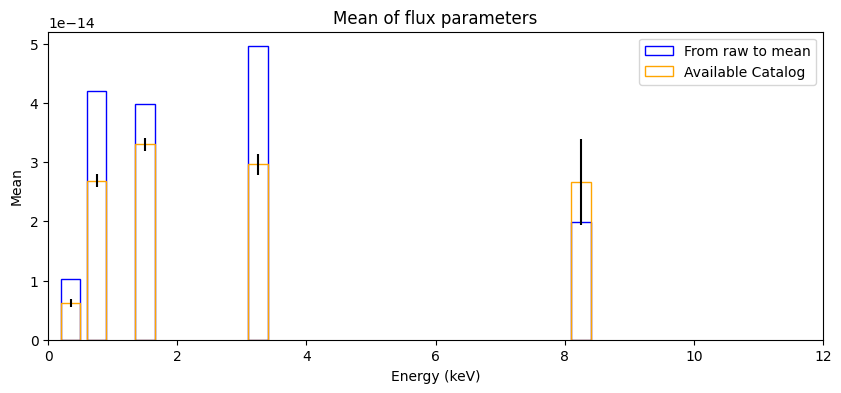

In [60]:
x=[0.2,0.5,1,2,4.5,12]
midx=[(x[i] + x[i+1])/2 for i in range(len(x)-1)]
#width=[(x[i+1]-x[i]) for i in range(len(x)-1)]
plt.figure(figsize=(10,4))

temp=[]
for i in range(1,6):
    temp.append(orion_mean[f"Flux_{i}"].mean())
plt.bar(midx,temp,width=0.3,fill=None,edgecolor="blue",label="From raw to mean") #,edgecolor='black')

temp=[]
temp_e=[]
for i in range(1,6):
    temp.append(xmm_crossmatched_orion[f"Flux{i}"].mean())
    temp_e.append(xmm_crossmatched_orion[f"e_Flux{i}"].mean())
plt.bar(midx,temp,yerr=temp_e,width=0.3,fill=None,edgecolor="orange",label="Available Catalog") #,edgecolor='black')

plt.xlim(0,12)
plt.xlabel("Energy (keV)")
plt.ylabel("Mean")
plt.title("Mean of flux parameters")
plt.legend()
#plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/Flux_distribution.pdf")

## Distribution du Flux_8

Mean dist to 1 (best is 0) 0.19


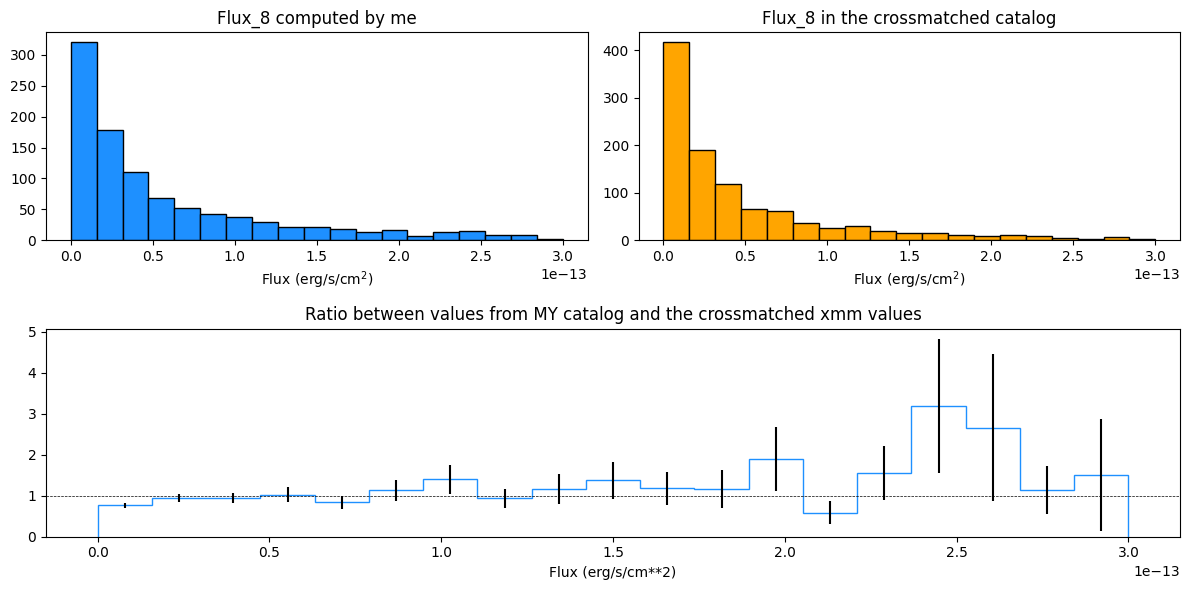

In [61]:
plt.figure(figsize=(12,6))
ax1=plt.subplot(2,2,1)
subset=orion_mean["Flux_8"]
bins=np.linspace(0,3e-13,20)
ax1.hist(subset,bins=bins,edgecolor='black',color="dodgerblue")
ax1.set_xlabel(r"Flux (erg/s/cm$^2$)")
ax1.set_title("Flux_8 computed by me")
ax2=plt.subplot(2,2,2)
#subset=all_xmm_raw["PN_8_FLUX"] #Tout le catalogue
subset=xmm_crossmatched_orion["Flux8"]
ax2.hist(subset,bins=bins,edgecolor='black',color='orange')
ax2.set_xlabel(r"Flux (erg/s/cm$^2$)")
ax2.set_title("Flux_8 in the crossmatched catalog")
plt.tight_layout()


#plt.figure(figsize=(10,4))
ax3=plt.subplot(2,1,2)
#bins=np.linspace(0,4e-13,20) #Le meme qu'au dessus
midbins=[(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
data1=np.histogram(orion_mean["Flux_8"],bins=bins)
#data2=np.histogram(all_xmm_raw["PN_8_FLUX"],bins=bins)
data2=np.histogram(xmm_crossmatched_orion["Flux8"],bins=bins)
ratio=data1[0]/data2[0]
steep=np.poly1d(np.polyfit(midbins,ratio,deg=1)[0])
errors=(data1[0]/data2[0]) * (np.sqrt(1/data1[0] + 1/data2[0]))
ax3.stairs(ratio,data1[1],color='dodgerblue')
ax3.errorbar(midbins,ratio,yerr=errors,c='black',linestyle='')
ax3.set_xlabel("Flux (erg/s/cm**2)")
ax3.set_title(f"Ratio between values from MY catalog and the crossmatched xmm values") #. Steepness: {steep}")
ax3.axhline(1,linestyle='dashed',c='black',linewidth=0.5)
print("Mean dist to 1 (best is 0)",round(np.mean(np.abs(ratio[errors<0.5]-1)),2)) #Take into account data with error < 0.5
plt.tight_layout()
#plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/Flux_8_analysis.pdf")


## Adding the homemade total flux to the crossmatched catalog

In [62]:
try:
    xmm_crossmatched_orion.add_column(orion_mean["Flux_8"] , name="Flux_8_Avg")
    xmm_crossmatched_orion.add_column(orion_mean["Flux_8_err"] , name="Flux_8_Avg_err")
except:
    xmm_crossmatched_orion.replace_column("Flux_8_Avg",orion_mean["Flux_8"])
    xmm_crossmatched_orion.replace_column("Flux_8_Avg_err",orion_mean["Flux_8_err"])
    
if n_ecf==1:
    try:
        xmm_crossmatched_orion.add_column(np.full(len(xmm_crossmatched_orion),np.nan) , name="Flux_6_Avg")
        xmm_crossmatched_orion.add_column(np.full(len(xmm_crossmatched_orion),np.nan) , name="Flux_7_Avg")
    except:
        xmm_crossmatched_orion.replace_column("Flux_6_Avg",np.full(len(xmm_crossmatched_orion),np.nan))
        xmm_crossmatched_orion.replace_column("Flux_7_Avg",np.full(len(xmm_crossmatched_orion),np.nan))
        
elif n_ecf==2:
    try:
        xmm_crossmatched_orion.add_column(orion_mean["Flux_6"] , name="Flux_6_Avg")
        xmm_crossmatched_orion.add_column(orion_mean["Flux_7"] , name="Flux_7_Avg")
        xmm_crossmatched_orion.add_column(orion_mean["PN_6_RATE"] , name="6_RATE_Avg")
        xmm_crossmatched_orion.add_column(orion_mean["PN_7_RATE"] , name="7_RATE_Avg")
    except:
        xmm_crossmatched_orion.replace_column("Flux_6_Avg",orion_mean["Flux_6"])
        xmm_crossmatched_orion.replace_column("Flux_7_Avg",orion_mean["Flux_7"])
        xmm_crossmatched_orion.replace_column("6_RATE_Avg",orion_mean["PN_6_RATE"])
        xmm_crossmatched_orion.replace_column("7_RATE_Avg",orion_mean["PN_7_RATE"])

### Showing differences between my computation of the Flux and the given one

Nbr de source totale: 1122
Nbr de sources considere dans l'histograme: 1035
Mean=-1.3587151988667695e-14, Median=-5.490509234533346e-15


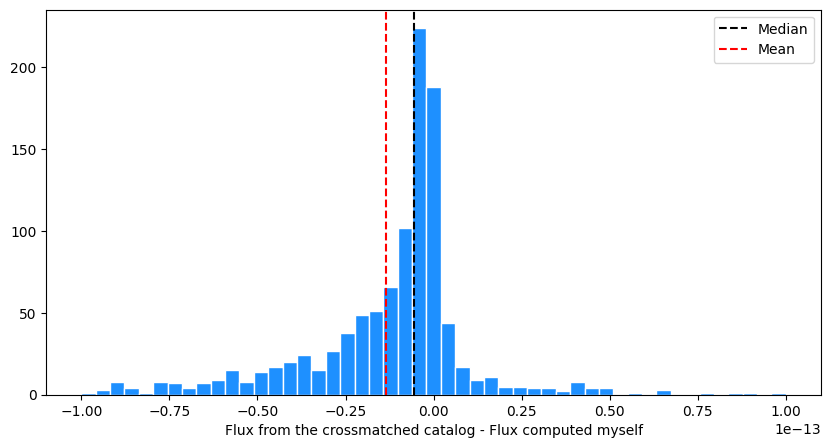

In [63]:
plt.figure(figsize=(10,5))
subset=xmm_crossmatched_orion["Flux8"]-xmm_crossmatched_orion["Flux_8_Avg"]
bins=np.linspace(-0.1e-12,0.1e-12,50)
a=plt.hist(subset,bins=bins,zorder=0,color="dodgerblue",edgecolor='white')
plt.xlabel("Flux from the crossmatched catalog - Flux computed myself")
med=np.median(subset[(subset<0.1e-12) & (subset>-0.1e-12)])
mean=np.mean(subset[(subset<0.1e-12) & (subset>-0.1e-12)])
plt.axvline(med,c='black',linestyle='dashed',label="Median",zorder=1)
plt.axvline(mean,c='red',linestyle='dashed',label="Mean",zorder=1)
plt.legend()
print("Nbr de source totale:",len(subset))
print("Nbr de sources considere dans l'histograme:",len(subset[(subset<0.1e-12) & (subset>-0.1e-12)]))
print(f"Mean={mean}, Median={med}")

Text(0.5, 1.0, 'Mine vs Given')

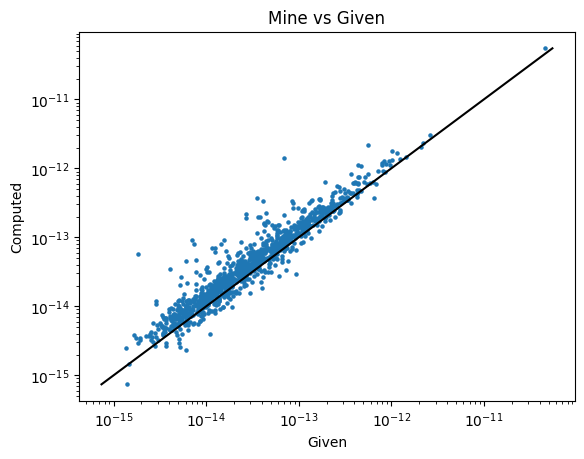

In [64]:
x=xmm_crossmatched_orion["Flux8"]
y=xmm_crossmatched_orion["Flux_8_Avg"]
lin=np.linspace(np.nanmin(list(x)+list(y)),np.nanmax(list(x)+list(y)),30)
plt.plot(lin,lin,c='black')
plt.scatter(x,y,s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Given")
plt.ylabel("Computed")
plt.title("Mine vs Given")


# Repartition du flux

## Ajout des flux Soft, Hard, et All

In [65]:
sub=orion_mean[(orion_mean["PN_4_RATE"]==0) & (orion_mean["PN_5_RATE"]==0)]
display(sub[:5])
print(len(sub))

DETID,SRCID,DR3SRCID,DR3DETID,DR3DETDIST,DR3SRCDIST,DR3MULT,DR4SRCID,DR4DETID,DR4DETDIST,DR4SRCDIST,DR4MULT,SRC_NUM,MJD_START,MJD_STOP,OBS_CLASS,RA,DEC,POSERR,LII,BII,RADEC_ERR,SYSERRCC,REFCAT,POSCOROK,RA_UNC,DEC_UNC,CCDPN,PN_RAWX,PN_RAWY,CCDM1,M1_RAWX,M1_RAWY,CCDM2,M2_RAWX,M2_RAWY,EP_1_FLUX,EP_1_FLUX_ERR,EP_2_FLUX,EP_2_FLUX_ERR,EP_3_FLUX,EP_3_FLUX_ERR,EP_4_FLUX,EP_4_FLUX_ERR,EP_5_FLUX,EP_5_FLUX_ERR,EP_8_FLUX,EP_8_FLUX_ERR,EP_9_FLUX,EP_9_FLUX_ERR,PN_1_FLUX,PN_1_FLUX_ERR,PN_2_FLUX,PN_2_FLUX_ERR,PN_3_FLUX,PN_3_FLUX_ERR,PN_4_FLUX,PN_4_FLUX_ERR,PN_5_FLUX,PN_5_FLUX_ERR,PN_8_FLUX,PN_8_FLUX_ERR,PN_9_FLUX,PN_9_FLUX_ERR,M1_1_FLUX,M1_1_FLUX_ERR,M1_2_FLUX,M1_2_FLUX_ERR,M1_3_FLUX,M1_3_FLUX_ERR,M1_4_FLUX,M1_4_FLUX_ERR,M1_5_FLUX,M1_5_FLUX_ERR,M1_8_FLUX,M1_8_FLUX_ERR,M1_9_FLUX,M1_9_FLUX_ERR,M2_1_FLUX,M2_1_FLUX_ERR,M2_2_FLUX,M2_2_FLUX_ERR,M2_3_FLUX,M2_3_FLUX_ERR,M2_4_FLUX,M2_4_FLUX_ERR,M2_5_FLUX,M2_5_FLUX_ERR,M2_8_FLUX,M2_8_FLUX_ERR,M2_9_FLUX,M2_9_FLUX_ERR,EP_8_RATE,EP_8_RATE_ERR,EP_9_RATE,EP_9_RATE_ERR,PN_1_RATE,PN_1_RATE_ERR,PN_2_RATE,PN_2_RATE_ERR,PN_3_RATE,PN_3_RATE_ERR,PN_4_RATE,PN_4_RATE_ERR,PN_5_RATE,PN_5_RATE_ERR,PN_8_RATE,PN_8_RATE_ERR,PN_9_RATE,PN_9_RATE_ERR,M1_1_RATE,M1_1_RATE_ERR,M1_2_RATE,M1_2_RATE_ERR,M1_3_RATE,M1_3_RATE_ERR,M1_4_RATE,M1_4_RATE_ERR,M1_5_RATE,M1_5_RATE_ERR,M1_8_RATE,M1_8_RATE_ERR,M1_9_RATE,M1_9_RATE_ERR,M2_1_RATE,M2_1_RATE_ERR,M2_2_RATE,M2_2_RATE_ERR,M2_3_RATE,M2_3_RATE_ERR,M2_4_RATE,M2_4_RATE_ERR,M2_5_RATE,M2_5_RATE_ERR,M2_8_RATE,M2_8_RATE_ERR,M2_9_RATE,M2_9_RATE_ERR,EP_8_CTS,EP_8_CTS_ERR,PN_8_CTS,PN_8_CTS_ERR,M1_8_CTS,M1_8_CTS_ERR,M2_8_CTS,M2_8_CTS_ERR,EP_8_DET_ML,EP_9_DET_ML,PN_1_DET_ML,PN_2_DET_ML,PN_3_DET_ML,PN_4_DET_ML,PN_5_DET_ML,PN_8_DET_ML,PN_9_DET_ML,M1_1_DET_ML,M1_2_DET_ML,M1_3_DET_ML,M1_4_DET_ML,M1_5_DET_ML,M1_8_DET_ML,M1_9_DET_ML,M2_1_DET_ML,M2_2_DET_ML,M2_3_DET_ML,M2_4_DET_ML,M2_5_DET_ML,M2_8_DET_ML,M2_9_DET_ML,EP_EXTENT,EP_EXTENT_ERR,EP_EXTENT_ML,EP_HR1,EP_HR1_ERR,EP_HR2,EP_HR2_ERR,EP_HR3,EP_HR3_ERR,EP_HR4,EP_HR4_ERR,PN_HR1,PN_HR1_ERR,PN_HR2,PN_HR2_ERR,PN_HR3,PN_HR3_ERR,PN_HR4,PN_HR4_ERR,M1_HR1,M1_HR1_ERR,M1_HR2,M1_HR2_ERR,M1_HR3,M1_HR3_ERR,M1_HR4,M1_HR4_ERR,M2_HR1,M2_HR1_ERR,M2_HR2,M2_HR2_ERR,M2_HR3,M2_HR3_ERR,M2_HR4,M2_HR4_ERR,PN_1_EXP,PN_2_EXP,PN_3_EXP,PN_4_EXP,PN_5_EXP,M1_1_EXP,M1_2_EXP,M1_3_EXP,M1_4_EXP,M1_5_EXP,M2_1_EXP,M2_2_EXP,M2_3_EXP,M2_4_EXP,M2_5_EXP,PN_1_BG,PN_2_BG,PN_3_BG,PN_4_BG,PN_5_BG,M1_1_BG,M1_2_BG,M1_3_BG,M1_4_BG,M1_5_BG,M2_1_BG,M2_2_BG,M2_3_BG,M2_4_BG,M2_5_BG,PN_PILEUP,M1_PILEUP,M2_PILEUP,PN_1_VIG,PN_2_VIG,PN_3_VIG,PN_4_VIG,PN_5_VIG,M1_1_VIG,M1_2_VIG,M1_3_VIG,M1_4_VIG,M1_5_VIG,M2_1_VIG,M2_2_VIG,M2_3_VIG,M2_4_VIG,M2_5_VIG,PN_ONTIME,M1_ONTIME,M2_ONTIME,EP_ONTIME,PN_OFFAX,M1_OFFAX,M2_OFFAX,EP_OFFAX,PN_MASKFRAC,M1_MASKFRAC,M2_MASKFRAC,DIST_NN,SUM_FLAG,TSERIES,SPECTRA,EP_CHI2PROB,PN_CHI2PROB,M1_CHI2PROB,M2_CHI2PROB,PN_FVAR,PN_FVARERR,M1_FVAR,M1_FVARERR,M2_FVAR,M2_FVARERR,VAR_FLAG,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,HIGH_BACKGROUND,PN_6_RATE,PN_7_RATE,Flux_1,Flux_2,Flux_3,Flux_4,Flux_5,Flux_6,Flux_7,Flux_8,Flux_8_err
,,,,arcsec,arcsec,,,,arcsec,arcsec,,,d,d,,deg,deg,arcsec,deg,deg,arcsec,arcsec,,,deg,deg,,,,,,,,,,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),er

68


In [66]:
d=xmm_crossmatched_orion["Distance"] *3.086*10**18 #Converti en cm

Lx_Soft=xmm_crossmatched_orion["Flux_6_Avg"]* 4*np.pi*d**2
Lx_Hard=xmm_crossmatched_orion["Flux_7_Avg"]* 4*np.pi*d**2
Lx_All =xmm_crossmatched_orion["Flux_8_Avg"]* 4*np.pi*d**2

#Lx_Soft[Lx_Soft==0] = np.nan #Bonne methode?
#Lx_Hard[Lx_Hard==0] = np.nan #Bonne methode?
#Lx_All[Lx_All==0]   = np.nan #Bonne methode?

In [67]:
try:
    xmm_crossmatched_orion.add_column(Lx_Soft , name="L_6_Avg")
    xmm_crossmatched_orion.add_column(Lx_Hard , name="L_7_Avg")
    xmm_crossmatched_orion.add_column(Lx_All , name="L_8_Avg")
except:
    xmm_crossmatched_orion.replace_column("L_6_Avg",Lx_Soft)
    xmm_crossmatched_orion.replace_column("L_7_Avg",Lx_Hard)    
    xmm_crossmatched_orion.replace_column("L_8_Avg",Lx_All)    

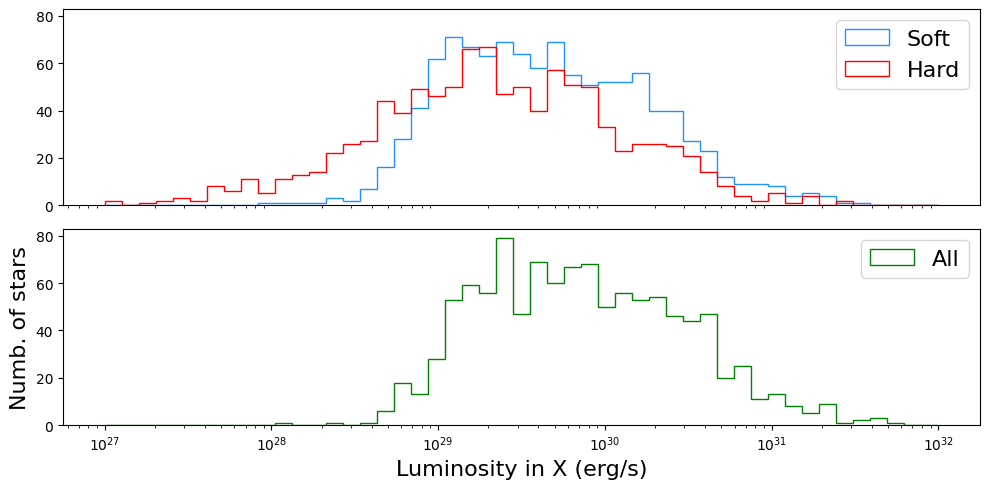

In [68]:
plt.figure(figsize=(10, 5))
bins = np.logspace(27, 32, 50, base=10)

ax1 = plt.subplot(2, 1, 1)
_ = ax1.hist(Lx_Soft, bins=bins, edgecolor='dodgerblue', color='dodgerblue', histtype='step', label='Soft')
_ = ax1.hist(Lx_Hard, bins=bins, edgecolor='red', color='red', histtype='step', label='Hard')
ax1.legend(fontsize=16)
plt.xscale('log')

ax2 = plt.subplot(2, 1, 2, sharey=ax1)
_ = ax2.hist(Lx_All, bins=bins, edgecolor='green', color='green', histtype='step', label='All')
ax2.legend(fontsize=16)
plt.xscale('log')
ax2.set_xlabel(r"Luminosity in X (erg/s)",fontsize=16)
ax2.set_ylabel(r"Numb. of stars"         ,fontsize=16)
# ax1.set_title("Luminosity in the averaged catalogue")
ax1.tick_params(bottom=False, labelbottom=False)
# ax1.set_xticklabels([])
plt.tight_layout()
plt.savefig("Images/Flux_Distribution.pdf")


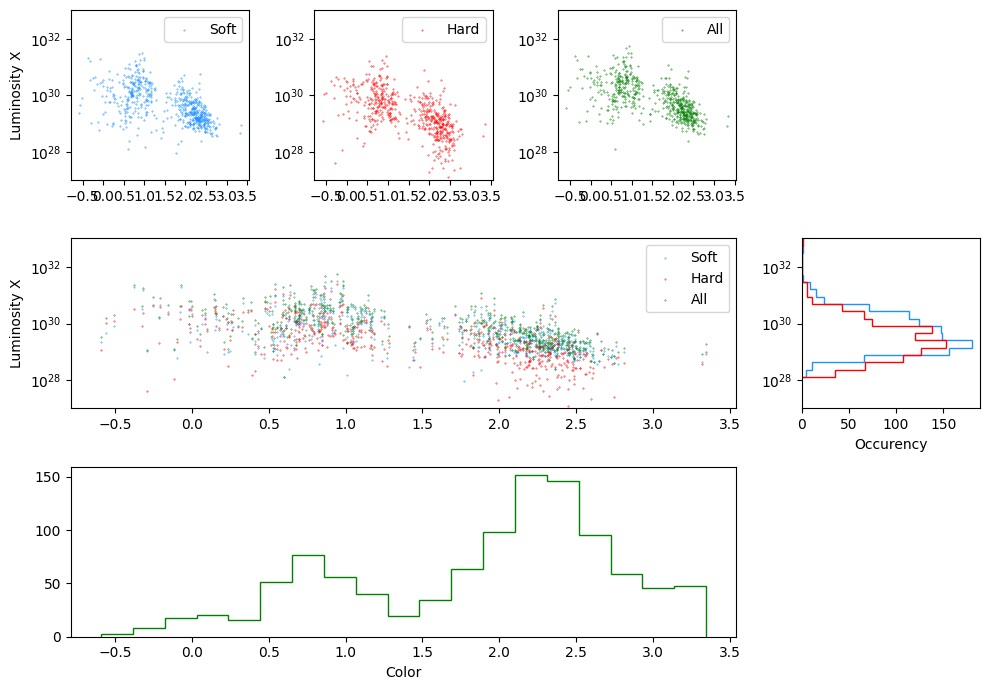

In [69]:
fig = plt.figure(figsize=(10,7) , constrained_layout=True)
gs  = fig.add_gridspec(3,4)
ax4 = fig.add_subplot(gs[1, 0:3])
x  =xmm_crossmatched_orion["BP-RP"] #Utiliser la couleur corrige????
x  =xmm_crossmatched_orion["Color_corrected"]

ax4.scatter(x,Lx_Soft,s=0.1,c='dodgerblue',label="Soft")
ax4.scatter(x,Lx_Hard,s=0.1,c='red',label="Hard")
ax4.scatter(x,Lx_All,s=0.1,c='green',label="All")
ax4.set_ylim(1e27,np.max(Lx_All))

#


ax4.set_yscale('log')
ax4.set_ylabel("Luminosity X")
ax4.legend()

ax1 = fig.add_subplot(gs[0, 0],sharex=ax4,sharey=ax4)
ax1.scatter(x,Lx_Soft,s=0.1,c='dodgerblue',label="Soft")
ax1.set_yscale('log')
ax1.set_ylabel("Luminosity X")
ax1.legend()



ax2 = fig.add_subplot(gs[0, 1],sharex=ax4,sharey=ax4)
ax2.scatter(x,Lx_Hard,s=0.1,c='red',label="Hard")
ax2.legend()

ax3 = fig.add_subplot(gs[0, 2],sharex=ax4,sharey=ax4)
ax3.scatter(x,Lx_All,s=0.1,c='green',label="All")
ax3.legend()

ax5 = fig.add_subplot(gs[2, 0:3],sharex=ax4)
bins=np.linspace(np.min(x),np.max(x),20)
t=ax5.hist(x,bins=bins,edgecolor='green',histtype='step')
ax5.set_xlabel("Color")

ax6 = fig.add_subplot(gs[1,3],sharey=ax4)
bins=np.logspace(np.log10(np.min(Lx_All)),np.log10(np.max(Lx_All)),20)
t=ax6.hist(Lx_Soft, bins=bins, orientation='horizontal'
         , histtype='step' ,edgecolor='dodgerblue',fill=False)
t=ax6.hist(Lx_Hard, bins=bins, orientation='horizontal'
         , histtype='step' ,edgecolor='red',fill=False)
ax6.set_xlabel("Occurency")
#t=ax6.hist(Lx_All, bins=bins, orientation='horizontal'
           #, histtype='step' ,edgecolor='green',fill=False)

plt.tight_layout()
    
#Depend de type d'objet?

26
202
225
519
140


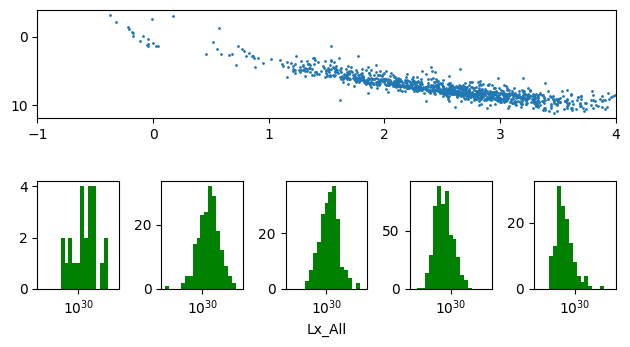

In [70]:
bins=np.linspace(-1,4,6)
x=xmm_crossmatched_orion["BP-RP"]
y=xmm_crossmatched_orion["Gabs"]

ax1=plt.subplot(3,1,1)
ax1.scatter(x,y,s=1)
ax1.set_xlim(-1,4)
plt.gca().invert_yaxis()

bins=np.logspace(28,32,20,base=10)
COLOR=xmm_crossmatched_orion["Color_corrected"]
Luminosity=Lx_All

subset=Luminosity[(COLOR>-1) & (COLOR<0)]
print(len(subset))
ax2=plt.subplot(3,5,6)
ax2.hist(subset,bins=bins,color='green')
ax2.set_xscale('log')

subset=Luminosity[(COLOR>0) & (COLOR<1)]
print(len(subset))
ax3=plt.subplot(3,5,7,sharex=ax2)
ax3.hist(subset,bins=bins,color='green')
#ax3.tick_params(left=None)

subset=Luminosity[(COLOR>1) & (COLOR<2)]
print(len(subset))
ax4=plt.subplot(3,5,8,sharex=ax2)
ax4.hist(subset,bins=bins,color='green')
ax4.set_xlabel("Lx_All")
#ax4.tick_params(left=None)

subset=Luminosity[(COLOR>2) & (COLOR<3)]
print(len(subset))
ax5=plt.subplot(3,5,9,sharex=ax2)
ax5.hist(subset,bins=bins,color='green')
#ax5.tick_params(left=None)

subset=Luminosity[(COLOR>3) & (COLOR<4)]
print(len(subset))
ax6=plt.subplot(3,5,10,sharex=ax2)
ax6.hist(subset,bins=bins,color='green')
#ax6.tick_params(left=None)
plt.tight_layout()

## Relative Error on Flux

Text(0.5, 0, 'Error/data')

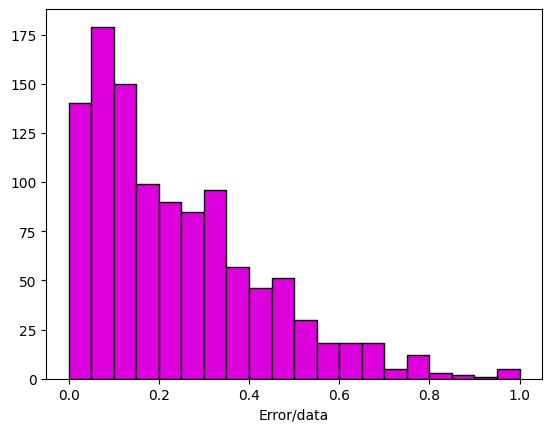

In [71]:
rate=xmm_crossmatched_orion["Flux_8_Avg"]
err=xmm_crossmatched_orion["Flux_8_Avg_err"]
relat_err=err/rate
a=plt.hist(relat_err,bins=20,range=(0,1),edgecolor='black',color="#DD01DD")
plt.xlabel("Error/data")

(array([42., 94., 95., 83., 70., 69., 49., 52., 48., 47., 45., 46., 34.,
        37., 38., 25., 16., 22., 19., 11.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

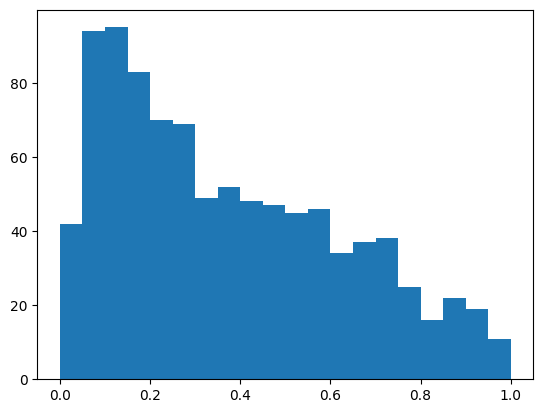

In [72]:
x=orion_mean["PN_8_FLUX"]
y=orion_mean["PN_8_FLUX_ERR"]
subset=y/x
plt.hist(subset,bins=20,range=(0,1))

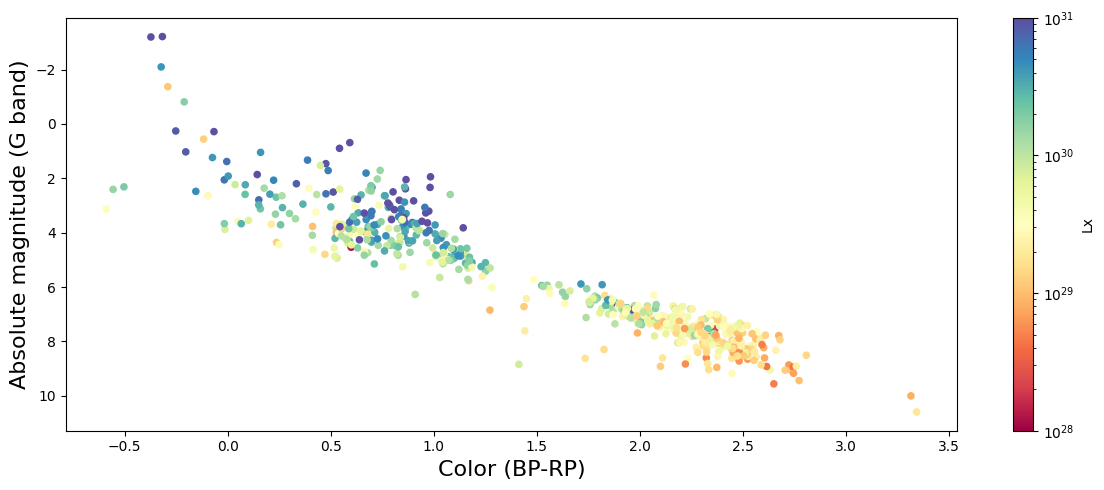

In [73]:
plt.figure(figsize=(12,5))
Gabs=xmm_crossmatched_orion["Gabs_corrected"]
Color = xmm_crossmatched_orion["Color_corrected"]

z=xmm_crossmatched_orion["L_8_Avg"]
a=plt.scatter(Color,Gabs,s=20,zorder=0,label='DATA',c=z 
            , norm=LogNorm(vmin=1e28 , vmax=1e31) , cmap='Spectral' )
plt.colorbar(label="Lx")
plt.gca().invert_yaxis()
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Absolute magnitude (G band)", fontsize=16)
#plt.title("View of the Lx luminosity on the HR diagram")

plt.tight_layout()
plt.savefig("Images/HR_Lx.png")

plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/HR_corrected_Colormap_LxAll.pdf")

#A mettre dans le diapo 
#Lx depend du type d'etoile

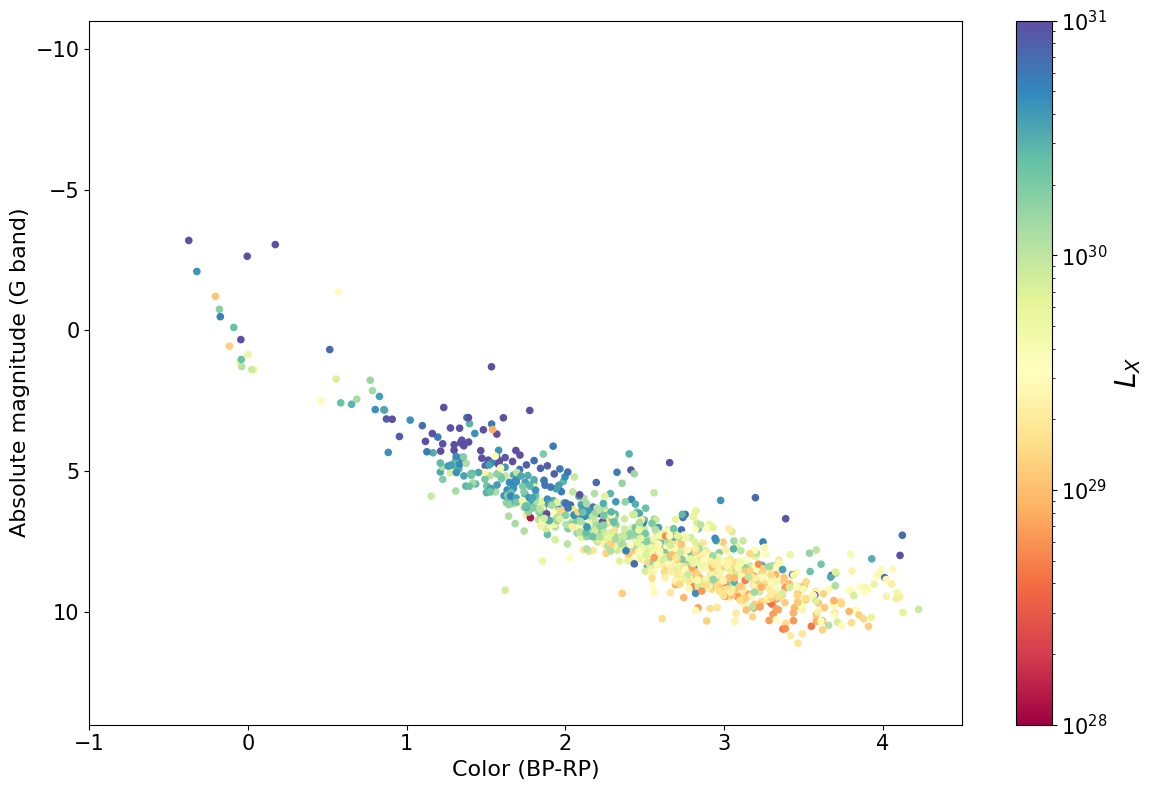

In [74]:
plt.figure(figsize=(12,8))
Gabs=xmm_crossmatched_orion["Gabs"]
Color = xmm_crossmatched_orion["BP-RP"]

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

z=xmm_crossmatched_orion["L_8_Avg"]
a=plt.scatter(Color,Gabs,s=20,zorder=0,label='DATA',c=z 
             , cmap='Spectral' , norm=LogNorm(vmin=1e28 , vmax=1e31))
plt.colorbar().set_label(label=r"$L_X$",fontsize=20)
plt.gca().invert_yaxis()
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Absolute magnitude (G band)", fontsize=16)
#plt.title("View of the Lx luminosity on the HR diagram")
#a voir si gdhb son les meme qu'en haut
g=-1
d=4.5
h=14
b=-11

plt.xlim(g,d)
plt.ylim(h,b)
plt.tight_layout()

plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/HR_Colormap_LxAll.pdf")

#Lx depend du type d'etoile

In [75]:
print(np.min(xmm_crossmatched_orion["L_8_Avg"]))

1.306329436671907e+28


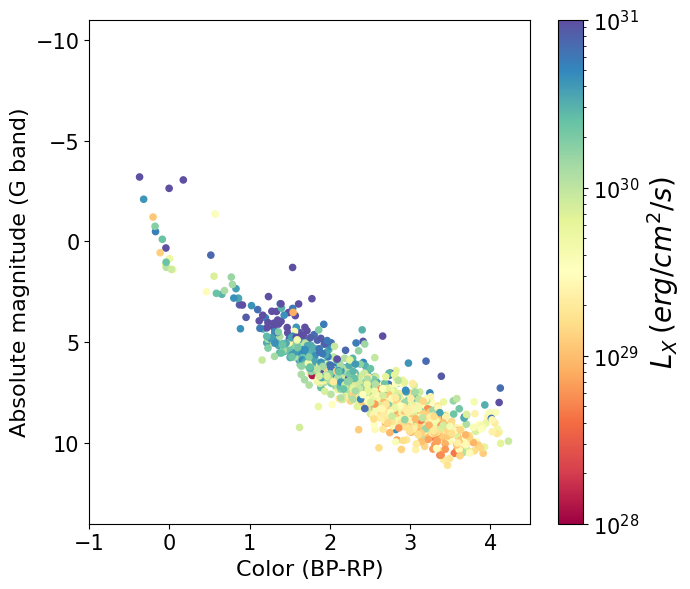

In [78]:
plt.figure(figsize=(7,6))
Gabs=xmm_crossmatched_orion["Gabs"]
Color = xmm_crossmatched_orion["BP-RP"]

z=xmm_crossmatched_orion["L_8_Avg"]
a=plt.scatter(Color,Gabs,s=20,zorder=0,label='DATA',c=z 
             , cmap='Spectral' , norm=LogNorm(vmin=1e28 , vmax=1e31))
plt.colorbar().set_label(label=r"$L_X\: (erg/cm^2/s)$",fontsize=20)
plt.gca().invert_yaxis()
plt.xlabel("Color (BP-RP)", fontsize=16)
plt.ylabel("Absolute magnitude (G band)", fontsize=16)
#plt.title("View of the Lx luminosity on the HR diagram")

plt.xlim(g,d)
plt.ylim(h,b)
plt.tight_layout()

plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/HR_Colormap_LxAll.png")

#A mettre dans le diapo 
#Lx depend du type d'etoile

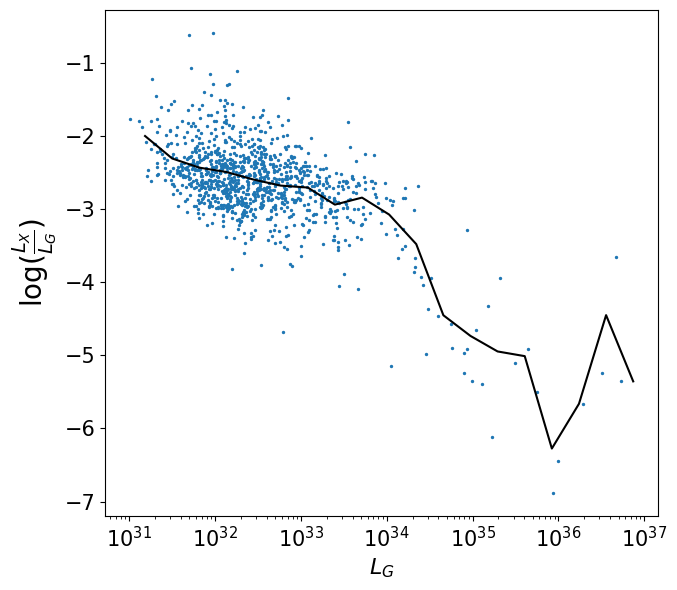

In [77]:
plt.figure(figsize=(7,6))
mask=((x<1e34) & (np.isnan(x)==False) & (np.isnan(y)==False))

x=3.846e33 * 10**((4.67-xmm_crossmatched_orion["Gabs"])/2.5)
y=xmm_crossmatched_orion["L_8_Avg"]
y=np.log10(y/x)

# space=np.linspace(1e31,1e34,200)
log=np.logspace(31,37,20)
midlog=(log[:-1]+log[1:])/2

plt.scatter(x,y,s=2,zorder=0,label='DATA')

# plt.scatter(x[mask],y[mask],s=20,zorder=1,c='red')

# steep,start=np.polyfit((x[mask]),(y[mask]),deg=1)

plt.xlabel(r"$L_G$", fontsize=16)
plt.ylabel(r"$\log(\frac{L_X}{L_G})$", fontsize=20)
#plt.title("View of the Lx luminosity on the HR diagram")

# plt.plot(space,space*steep+start)
# plt.axhline(1e31*steep+start,c='red',linestyle='dashed')
plt.xscale('log')
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.tight_layout()

moyenne=[]
std=[]
for i in range(len(log)-1):
    MASK=(x<log[i+1]) & (x>log[i])
    moyenne.append(np.mean(y[MASK]))
    std.append(np.sqrt(np.mean((y[MASK]-np.mean(y[MASK]))**2)))
#     plt.axvline(log[i])
# plt.axvline(log[-1])
std=np.array(std)
plt.plot(midlog,moyenne,c='black')
# plt.scatter(midlog,moyenne+std,c='black')
# plt.fill_between(midlog,)
plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Rapport_L.png")

#A mettre dans le diapo 
#Lx depend du type d'etoile

In [ ]:
plt.figure(figsize=(12,5))
mask=((x<1e34) & (np.isnan(x)==False) & (np.isnan(y)==False))

x=3.846e33 * 10**((4.67-xmm_crossmatched_orion["Gabs"])/2.5)
y=xmm_crossmatched_orion["L_8_Avg"]
y=np.log10(y/x)

# space=np.linspace(1e31,1e34,200)
log=np.logspace(31,37,20)
midlog=(log[:-1]+log[1:])/2

plt.scatter(x,y,s=2,zorder=0,label='DATA')

# plt.scatter(x[mask],y[mask],s=20,zorder=1,c='red')

# steep,start=np.polyfit((x[mask]),(y[mask]),deg=1)

plt.xlabel(r"$L_g$ (erg/s)"                       , fontsize=18)
plt.ylabel(r"$\log_{10}(\frac{L_X}{L_G})$", fontsize=18)
#plt.title("View of the Lx luminosity on the HR diagram")

# plt.plot(space,space*steep+start)
# plt.axhline(1e31*steep+start,c='red',linestyle='dashed')
plt.xscale('log')
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.tight_layout()

moyenne=[]
for i in range(len(log)-1):
    MASK=(x<log[i+1]) & (x>log[i])
    moyenne.append(np.mean(y[MASK]))
#     plt.axvline(log[i])
# plt.axvline(log[-1])
plt.plot(midlog,moyenne,c='black')
plt.tight_layout()
plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/LG_over_LX.pdf")

#A mettre dans le diapo 
#Lx depend du type d'etoile

In [ ]:
print(steep,start)
print(len(x[mask]))
print(len(x))
print(space*steep+start)

In [ ]:
a="Teff"
b="HR"
x=xmm_crossmatched_orion[a]
y=xmm_crossmatched_orion[b]
plt.scatter(x,y,s=5)
plt.xlabel(a,fontsize=16)
plt.ylabel(b,fontsize=16)
#plt.yscale("log")
#plt.xscale("log")

# Calcul du Hardness ratio entre Soft et Hard

In [ ]:
Soft=xmm_crossmatched_orion["6_RATE_Avg"]
Hard=xmm_crossmatched_orion["7_RATE_Avg"]
HR=(Hard-Soft)/(Soft+Hard)
try:
    xmm_crossmatched_orion.add_column(HR,name="HR")
except:
    xmm_crossmatched_orion.replace_column("HR",HR)

### Analyse du HR

In [ ]:
subset=xmm_crossmatched_orion["HR"]
plt.figure(figsize=(12,4))
plt.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
plt.text(0.75,0.5,"Hard",transform=plt.gca().transAxes , ha='center' , va='center')
plt.text(0.25,0.5 ,"Soft",transform=plt.gca().transAxes , ha='center' , va='center')
plt.xlabel(r"HR ($\frac{Hard-Soft}{Hard+Soft}$)",fontsize=16)
plt.ylabel("Numb. of stars"                ,fontsize=16)
bins=np.linspace(-1,1,50)

_=plt.hist(subset,bins=bins,edgecolor='black')

# plt.title("Hardness ratio of the sample")
plt.tight_layout()
plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Hardness_Ratio.pdf")

In [ ]:
fig=plt.figure(figsize=(12,6))
bins=np.linspace(-1,1,50)

ax1=plt.subplot(4,1,1)
subset=orion_mean["PN_HR1"]
#subset=subset[(subset>-1) & (subset<1)]
ax1.hist(subset,bins=bins,label="HR1")
ax1.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
ax1.text(0.75,0.5,"Harder",transform=plt.gca().transAxes , ha='center' , va='center')
ax1.text(0.25,0.5 ,"Softer",transform=plt.gca().transAxes , ha='center' , va='center')
ax1.set_xlabel(r"$\frac{CTR_2 - CTR_1}{CTR_1 + CTR_2}$")
ax1.legend()
ax1.tick_params(labelbottom=None,bottom=None)

ax2=plt.subplot(4,1,2)
subset=orion_mean["PN_HR2"]
#subset=subset[(subset>-1) & (subset<1)]
ax2.hist(subset,bins=bins,label="HR2")
ax2.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
ax2.text(0.75,0.5,"Harder",transform=plt.gca().transAxes , ha='center' , va='center')
ax2.text(0.25,0.5 ,"Softer",transform=plt.gca().transAxes , ha='center' , va='center')
ax2.set_xlabel(r"$\frac{CTR_3 - CTR_2}{CTR_2 + CTR_3}$")
ax2.legend()
ax2.tick_params(labelbottom=None,bottom=None)

ax3=plt.subplot(4,1,3)
subset=orion_mean["PN_HR3"]
#subset=subset[(subset>-1) & (subset<1)]
ax3.hist(subset,bins=bins,label="HR3")
ax3.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
ax3.text(0.75,0.5,"Harder",transform=plt.gca().transAxes , ha='center' , va='center')
ax3.text(0.25,0.5 ,"Softer",transform=plt.gca().transAxes , ha='center' , va='center')
ax3.set_xlabel(r"$\frac{CTR_4 - CTR_3}{CTR_3 + CTR_4}$")
ax3.legend()
ax3.tick_params(labelbottom=None,bottom=None)

ax4=plt.subplot(4,1,4)
subset=orion_mean["PN_HR4"]
#subset=subset[(subset>-1) & (subset<1)]
ax4.hist(subset,bins=bins,label="HR4")
ax4.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
ax4.text(0.75,0.5,"Harder",transform=plt.gca().transAxes , ha='center' , va='center')
ax4.text(0.25,0.5 ,"Softer",transform=plt.gca().transAxes , ha='center' , va='center')
ax4.set_xlabel(r"$\frac{CTR_5 - CTR_4}{CTR_4 + CTR_5}$")
ax4.legend()

plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,4))
Soft=xmm_crossmatched_orion["6_RATE_Avg"]
Hard=xmm_crossmatched_orion["7_RATE_Avg"]
HR=(Hard-Soft)/(Soft+Hard)
L=xmm_crossmatched_orion["L_8_Avg"]
m=(HR>-1) & (HR<1)
#HR=HR[m]
#L=L[m]

plt.scatter(HR,L,s=1)

plt.axvline(0,c='black',linestyle='dashed',linewidth=0.5)
plt.text(0.75,0.5,"Hard",transform=plt.gca().transAxes , ha='center' , va='center')
plt.text(0.25,0.5 ,"Soft",transform=plt.gca().transAxes , ha='center' , va='center')
plt.yscale('log')
plt.xlabel("HR")
plt.ylabel("Lx_all")

In [ ]:
plt.figure(figsize=(12,4))
Gabs=xmm_crossmatched_orion["Gabs"]
Color = xmm_crossmatched_orion["BP-RP"]

z=xmm_crossmatched_orion["HR"]
a=plt.scatter(Color,Gabs,s=20,zorder=0,label='DATA',c=z 
            , cmap='Spectral',norm=PowerNorm(gamma=0.4))
plt.colorbar(label="HR", pad=0.01)

plt.xlim(g, d)
plt.ylim(h, b)

# plt.title("Population seeking with Hardness Ratio")
# plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/HR_Colormap_Hardness_Ratio.pdf")

In [ ]:
plt.figure(figsize=(12,4))
Gabs=xmm_crossmatched_orion["Gabs"][xmm_crossmatched_orion["HR"]>0]
Color = xmm_crossmatched_orion["BP-RP"][xmm_crossmatched_orion["HR"]>0]

z=xmm_crossmatched_orion["HR"][xmm_crossmatched_orion["HR"]>0]
a=plt.scatter(Color,Gabs,s=20,zorder=0,label='DATA',c=z 
            , cmap='Spectral')
plt.colorbar(label="HR", pad=0.01)
plt.xlim(g, d)
plt.ylim(h, b)

# plt.title("Population seeking with Hardness Ratio")
plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/HR_Colormap_Hardness_Ratio.pdf")

# Recup les RA DEC (gaia) pour crossmatch avec Simbad

In [ ]:
display(xmm_crossmatched_orion[:1])

ra=xmm_crossmatched_orion["RAdeg"]
dec=xmm_crossmatched_orion["DEdeg"]
co=zip(ra,dec)

coordinates=SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')

Simbad.reset_votable_fields()
Simbad.add_votable_fields("otype","distance_result","sp")
print(Simbad.get_votable_fields())
#Simbad.get_field_description('otype')
result_table = Simbad.query_region(coordinates , radius=1 * u.arcsec)
print(len(result_table))

In [ ]:
Simbad.list_votable_fields()

In [ ]:
result_table = Simbad.query_region(coordinates , radius=1 * u.arcsec)
#result_table.info

In [ ]:
print(len(result_table))
display(result_table[:1])

In [ ]:
Simbad.get_votable_fields()

In [ ]:
subset=result_table["MAIN_ID"]
#plt.hist(subset)

In [ ]:
#Just to initilalise colnames and column we want (otype, distane_results)
temp=SkyCoord(ra=ra[0], dec=dec[0], unit=(u.deg, u.deg), frame='icrs')
Simbad.reset_votable_fields()
Simbad.add_votable_fields("otype","distance_result")
print(Simbad.get_votable_fields())
result_table = Simbad.query_region(temp , radius=0.1 * u.arcsec)
print(len(result_table))

In [ ]:
final=Table(names=result_table.colnames,dtype=result_table.dtype)
i=0

for coord in coordinates:
    result_table = Simbad.query_region(coord, radius=1 *u.arcsec)
    if result_table is None:
        pass
    else:
        final.add_row(result_table[result_table["DISTANCE_RESULT"]==np.min(result_table["DISTANCE_RESULT"])][0])
    i+=1
    if i % 200 == 0:
        print(i)

display(final[:2])

In [ ]:
print(len(final))

In [ ]:
subset=final["SP_TYPE"]
print(len(np.unique(subset)),"objets uniques")

plt.figure(figsize=(13,5))
ax = plt.subplot(1,1,1)
h,edges,_ = ax.hist(subset,edgecolor='white',bins=len(np.unique(subset))-1,align='left')
#ax.tick_params(labelsize=5)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plt.savefig("/home/thomas/Documents/0_Stage/Code/Images/Important/Otypes.pdf")

In [ ]:
print(len(subset))

# Stockage de la table xmm_orion COMPLETE

In [ ]:
xmm_crossmatched_orion.write('./Tables/finished_table.fits',format='fits',overwrite=True)

# Utile

In [ ]:
a=
'''
subset=
x,p,mean,std=Gaussian_fit(?,?,subset)
plt.hist(subset,bins=Sturge(subset),range=[?,?],density=True)
plt.plot(x,p,color='black')
plt.title("Fit Values: mean:{:.2f} | standard deviation:{:.2f}".format(mean, std))
'''

In [ ]:
'''
test=conesearch(url_obs_xmm,[084.34409174 , -06.79672529],3,"deg")
test.write('./Tables/observations.fits',format='fits',overwrite=True)
display(test)
'''

In [ ]:
#Pour avoir les infos d'une colone
'''
colone.info
'''

In [ ]:
#c=SkyCoord(ra=test["RAJ2000"],dec=test["DEJ2000"],frame='icrs')
#glon=c.galactic.l
#glat=c.galactic.b
#test.add_columns([glon,glat],names=["glon","glat"])
mark=[]
t=Time(test["MJD0"][0],format='mjd').to_value('datetime')
print(t.year)
#np.sort()
plt.figure(figsize=(20,8))
for i in range(len(test)):
    plt.text(test["glon"][i],test["glat"][i],Time(test["MJD0"][i],format='mjd').to_value('datetime').year,rotation=45,fontsize=12)
plt.scatter(test["glon"],test["glat"])
plt.gca().invert_xaxis()

In [ ]:
mask_test=(xmm_crossmatched["e_Plx"]/xmm_crossmatched["Plx"] <0.05)

In [ ]:
print(len(xmm_crossmatched[mask_test & megamask_cross])/len(xmm_crossmatched) *100,"% kept")

In [ ]:
#Faire des density map
N = 1000000
x = np.random.normal(4, 2, N)
y = np.random.normal(3, 1, N)



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.scatter_density(x, y,cmap='Spectral')
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

## Compter sans les masks

In [ ]:
my_list = [1, 2, np.ma.masked, 4, np.ma.masked]
filtered_list = [x for x in my_list if not np.ma.is_masked(x)]
length = len(filtered_list)

print(length)


In [ ]:
file="/home/thomas/Documents/0_Stage/Code/Tables/cone_TESS.fits"
fits.info(file)
fits.getdata(file, ext=1).columns
with fits.open(file) as hdul:
    res=Table(hdul[1].data)

In [ ]:
display(ALL[0])

In [ ]:
def moyenne_olympiade(liste):
    liste[liste.index(np.min(liste))]=np.nan
    return round(np.nanmean(liste),1)
dic={"Renaud":[15,16,16,14,0]
     ,"Samuel":[16,17,18,18,15]
     ,"Thomas":[12.5,19.5,17,11,9]
     ,"Matteo":[13,11,18.25,19,12]
     ,"Nicolas":[14,18,14,14,11,0]
     ,"Loan":[15,9,0,0,0]
}

nom=["Renaud","Samuel","Thomas","Matteo","Nicolas","Loan"]

for name in nom:
    print(name,moyenne_olympiade(dic[name]),"\n")

In [ ]:
dic={"R":[1,2,3],"S":[4,5,6]}
print(dic["R"])